In [150]:
import numpy as np
from copy import deepcopy
import math
import time
import matplotlib.pyplot as plt

def draw_line_chart(x, y, title, x_label, y_label):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

def draw_scatter_plot(x, y, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.grid(True)
    plt.show()


np.random.seed(1)

def relu(x):
    return x * (x > 0)

def derivative_relu(x):
    return 1. * (x > 0)

def tanh(x):
    return np.tanh(x)

def derivative_tanh(x):
    return 1- np.tanh(x)**2


def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def derivative_sigmoid(x):
    return np.multiply(x,1.0 - x)

def no_function(X):
    return X


class Optimizer:
    def __init__(self):
        pass

    def calc(self,gradient):
        return None



class Momentum(Optimizer):
    m = 0.9
    # v^t = [ learning_rate * gradient           t=0
    #       [ mv(t-1) + learning_rate * gradient t>=1
    #
    # theta = theta - v(t)

    last_v = None
    def __init__(self,m=0.9):
        self.m = m
    
    # calc  v^(t)
    def calc(self,gradient):
        if (self.last_v is None):
            ret = gradient
        else:
            ret = self.last_v * self.m + gradient
        self.last_v = ret
        return ret
class nn:
    # activate function
    #    py funfiton
    # input
    #    np.array
    # output
    #    np.array
    
    W = None
    b = None
    dW = None
    db = None
    activate_function = None
    derivative_function = None
    a_output = None # self a Value (after activation)
    a_input = None # input (or last layer output)
    optimizer = None
    bias_optimizer = None
    def __init__(self,input,output,activate_function=no_function,derivative_function =no_function,weight_optimizer=None,bias_optimizer=None):
        self.W = np.random.rand(input,output) # default value
        self.b = np.random.rand(1,output)
        self.activate_function = activate_function # for all value pass the activate function get the result
        self.derivative_function = derivative_function # for all value pass the activate function get the result
        self.weight_optimizer = weight_optimizer
        self.bias_optimizer = bias_optimizer
        pass
    def forward(self,feature):
        # give feature with size input then result size output feature
        # linear function
        # y = σ(WX + b)
        self.a_input = feature
        self.a_output = self.activate_function(np.dot(feature,self.W) + self.b) 

        return self.a_output
    def backward(self,output_error):
        z = output_error * self.derivative_function(self.a_output)  # calc this layer new error
        #print("->",self.a_input.T.shape,z.shape)
        self.dW = np.dot(self.a_input.T , z)
        self.db = np.sum(z, axis=0, keepdims=True)
        #print(dW.shape)
        #print(self.W.shape)
        return np.dot(z, self.W.T)
    
    def update(self,learning_rate):
        if (self.weight_optimizer != None and self.bias_optimizer!= None ):
            self.W -= self.weight_optimizer.calc(learning_rate * self.dW)
            self.b -= self.bias_optimizer.calc(learning_rate * self.db)
        else:
            self.W -= learning_rate * self.dW
            self.b -= learning_rate * self.db

class model:
    network = []
    optimizer = None
    memory_learning_epoch = [] 
    memory_learning_curve_loss = []
    memory_learning_curve_accuracy = []
    memory_epoch = 100
    def __init__(self,memory_epoch=100):
        self.memory_epoch = memory_epoch
        pass
    def clear(self):
        self.network = []
        self.memory_learning_epoch = [] 
        self.memory_learning_curve_loss = []
        self.memory_learning_curve_accuracy = []
    def set_optimizer(self,optimizer):
        self.optimizer = optimizer
    def add_layer(self,input,output,activate_function=no_function,derivative_function=no_function):
        weight_optimizer = deepcopy(self.optimizer)
        bias_optimizer = deepcopy(self.optimizer)
        self.network.append(nn(input,output,activate_function,derivative_function,weight_optimizer,bias_optimizer))
    def forward(self,last_feature):
        #last_feature = None # input data

        for layer in self.network:
            last_feature = layer.forward(last_feature)
        prediction = last_feature
        
        # last_feature is the last result
        return prediction

    def backward(self,y,pred_y):
        error = -2*(y - pred_y) # L2'
        #print(error.shape)
        for layer in reversed(self.network):
            error = layer.backward(error)
        
    
    def update(self,learning_rate):
        for layer in self.network:
            layer.update(learning_rate)

    def training(self,n,training_data,ground_truth,learning_rate=0.1,show_info=5000,batch=32):
        print("---START TRAINING---")
        t_st = time.time()
        training_set = np.hstack((training_data,ground_truth))
        tot_dataset = len(training_data)
        acc = None
        for epoch in range(n):
            
            np.random.shuffle(training_set)
            batch_training_data = training_set[:,:-1]
            batch_prediction = training_set[:,-1:]
            for i in range(int(math.ceil(tot_dataset / batch))):    
                st = batch * i
                ed = min(batch * (i+1),tot_dataset)
                
                prediction = self.forward(batch_training_data[st:ed])
                # backward pass compute \delta weights
                self.backward(batch_prediction[st:ed],prediction)

                # update
                self.update(learning_rate)
            
            if (epoch+1) % show_info == 0:
                prediction = self.forward(training_data)
                acc = self.calc_accuracy(ground_truth,prediction)
                loss = self.calc_loss(ground_truth,prediction)
                if (epoch+1) % self.memory_epoch == 0:
                    self.memory_learning_epoch.append(epoch+1)
                    self.memory_learning_curve_loss.append(loss)
                    self.memory_learning_curve_accuracy.append(acc)
                print(f"epoch {epoch+1:8d}: loss : {loss:.10f}") #accuracy={acc:03.2f}%
            
                #if (acc == 100):
                #    break
            elif (epoch+1) % self.memory_epoch == 0:
                prediction = self.forward(training_data)
                acc = self.calc_accuracy(ground_truth,prediction)
                loss = self.calc_loss(ground_truth,prediction)
                self.memory_learning_epoch.append(epoch+1)
                self.memory_learning_curve_loss.append(loss)
                self.memory_learning_curve_accuracy.append(acc)

        if acc == None:
            prediction = self.forward(training_data)
            acc = self.calc_accuracy(ground_truth,prediction)
        #print(f"last accuracy={acc:03.2f}%")
        print(f"spent: {time.time()-t_st}s")
        print("---FINISH TRAINING---")
    def calc_loss(self, y, y_pred):
        return np.mean(np.square(y - y_pred))

    def calc_accuracy(self,y,y_pred):
        n = len(y)
        return (y == (y_pred > 0.5)).sum()*100 / n
    def testing(self,training_data,ground_truth,show_info=True):
        prediction = self.forward(training_data)
        for i in range(len(training_data)):
            if (not show_info):
                break
            print(f"Iter {i:3d} |    Ground truth: {ground_truth[i][0]:f} |   prediction: {prediction[i][0]:f} |")
        loss = self.calc_loss(ground_truth,prediction)
        acc = self.calc_accuracy(ground_truth,prediction)
        print(f"loss={loss:.4f} accuracy={acc:03.2f}%")
        return prediction
    def show_learning_curve_loss(self):
        draw_line_chart(self.memory_learning_epoch,self.memory_learning_curve_loss,'Loss curve','epoch','loss')
    
    def show_learning_curve_accuracy(self):
        draw_line_chart(self.memory_learning_epoch,self.memory_learning_curve_accuracy,'Accuracy curve','epoch','Accuracy')
def generate_linear(n=100):
    import numpy as np
    pts = np.random.uniform(0,1,(n,2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0],pt[1]])
        distance = (pt[0] - pt[1] ) / 1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n,1)
def generate_XOR_easy():
    import numpy as np
    inputs = []
    labels = []
    
    for i in range(11):
        inputs.append([0.1*i,0.1*i])
        labels.append(0)
        
        if 0.1 * i == 0.5:
            continue
        
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
        
    return np.array(inputs), np.array(labels).reshape(21,1)

def generate_XOR_hard():
    import numpy as np
    inputs = []
    labels = []

    for i in range(101):
        for j in range(101):
            x1 = 0.01 * i
            x2 = 0.01 * j
            inputs.append([x1, x2])
            labels.append(int((x1 > 0.5) != (x2 > 0.5)))

    return np.array(inputs), np.array(labels).reshape(-1, 1)

def generate_XOR_hard_2(noise_level=0.1):
    inputs = []
    labels = []

    for i in range(101):
        for j in range(101):
            x1 = 0.01 * i
            x2 = 0.01 * j
            # 引入隨機噪音
            x1_noisy = x1 + np.random.uniform(-noise_level, noise_level)
            x2_noisy = x2 + np.random.uniform(-noise_level, noise_level)
            inputs.append([x1_noisy, x2_noisy])
            labels.append(int((x1 > 0.5) != (x2 > 0.5)))

    return np.array(inputs), np.array(labels).reshape(-1, 1)


def show_result(x,y, pred_y):
    import matplotlib.pyplot as plt
    plt.subplot(1,2,1)
    plt.title('Ground truth',fontsize=18)
    for i in range(x.shape[0]):
        if (y[i] == 0):
            plt.plot(x[i][0],x[i][1],'ro')
        else:
            plt.plot(x[i][0],x[i][1],'bo')
    
    plt.subplot(1,2,2)
    plt.title('Predict result',fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0],x[i][1],'ro')
        else:
            plt.plot(x[i][0],x[i][1],'bo')
    plt.show()

In [189]:
from sklearn.datasets import make_circles, make_moons
circle_x, circle_y = make_circles(n_samples=200, noise=0.1, factor=0.5)
moon_x, moon_y = make_moons(n_samples=200, noise=0.1)
circle_x = np.array(circle_x)
circle_y = np.array(circle_y).reshape(-1,1)
moon_x = np.array(moon_x)
moon_y = np.array(moon_y).reshape(-1,1)
xor_hard_x,xor_hard_y = generate_XOR_hard()
xor_hard_2_x,xor_hard_2_y = generate_XOR_hard_2()


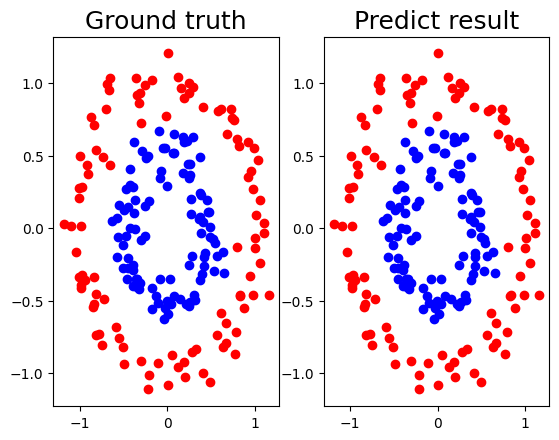

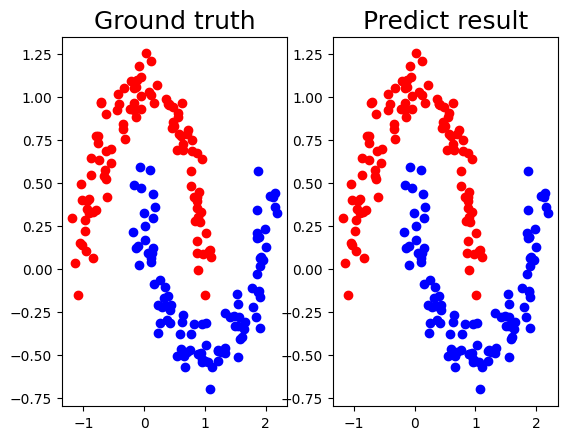

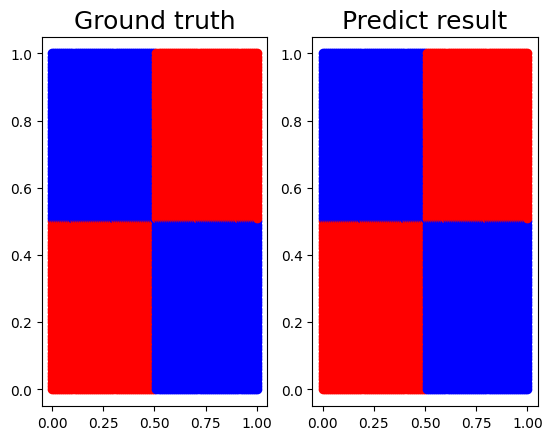

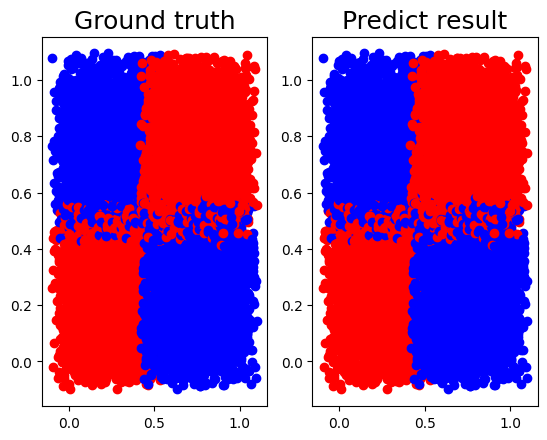

In [190]:
show_result(circle_x,circle_y,(circle_y > 0.5))
show_result(moon_x,moon_y,(moon_y > 0.5))
show_result(xor_hard_x,xor_hard_y,(xor_hard_y > 0.5))
show_result(xor_hard_2_x,xor_hard_2_y,(xor_hard_2_y > 0.5))

# no optimizer , only SGD, batch = 32, learning_rate = 0.1, epoch = 10k, 2,4,4,1 all sigmoid

---START TRAINING---
epoch     1000: loss : 0.0042380260
epoch     2000: loss : 0.0238643824
epoch     3000: loss : 0.0061306842
epoch     4000: loss : 0.0033579711
epoch     5000: loss : 0.0014456249
epoch     6000: loss : 0.0003044721
epoch     7000: loss : 0.0001621299
epoch     8000: loss : 0.0001091968
epoch     9000: loss : 0.0000816992
epoch    10000: loss : 0.0000645244
spent: 3.659114122390747s
---FINISH TRAINING---
Iter   0 |    Ground truth: 1.000000 |   prediction: 0.999998 |
Iter   1 |    Ground truth: 0.000000 |   prediction: 0.000005 |
Iter   2 |    Ground truth: 0.000000 |   prediction: 0.000005 |
Iter   3 |    Ground truth: 1.000000 |   prediction: 0.998062 |
Iter   4 |    Ground truth: 1.000000 |   prediction: 0.999998 |
Iter   5 |    Ground truth: 0.000000 |   prediction: 0.000005 |
Iter   6 |    Ground truth: 1.000000 |   prediction: 0.999998 |
Iter   7 |    Ground truth: 1.000000 |   prediction: 0.999998 |
Iter   8 |    Ground truth: 1.000000 |   prediction: 0.9999

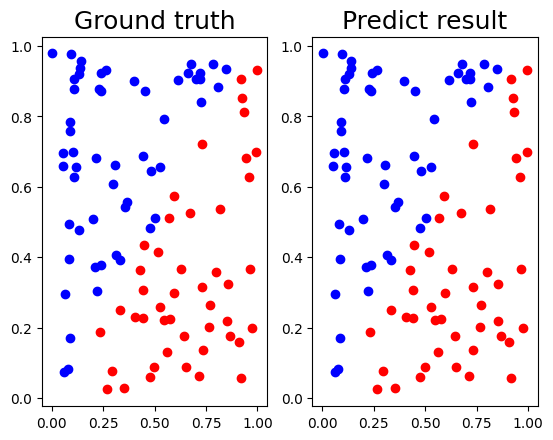

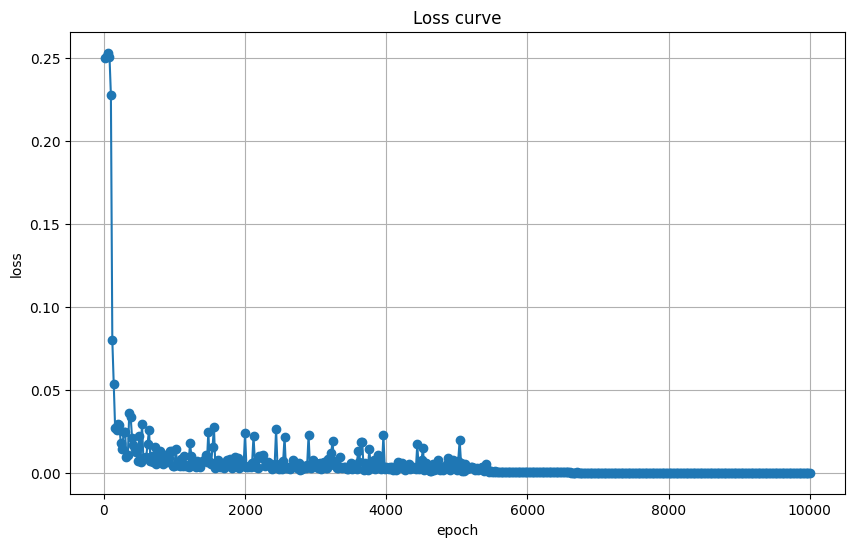

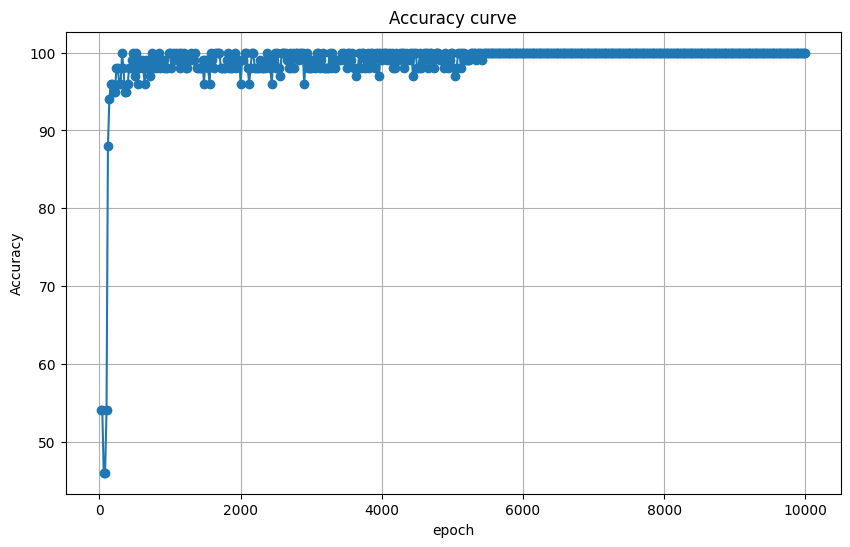

In [158]:
x,y = generate_linear(n = 100)
m = model(memory_epoch=20)
m.clear()
m.add_layer(2,4,sigmoid,derivative_sigmoid)
m.add_layer(4,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(10000,x,y,0.1,1000,batch=32)
pred_y = m.testing(x,y,show_info=True)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch     1000: loss : 0.2484968851
epoch     2000: loss : 0.1993588533
epoch     3000: loss : 0.0471286351
epoch     4000: loss : 0.0438679142
epoch     5000: loss : 0.0435439540
epoch     6000: loss : 0.0434442117
epoch     7000: loss : 0.0433983630
epoch     8000: loss : 0.0433726142
epoch     9000: loss : 0.0433563199
epoch    10000: loss : 0.0433451606
spent: 0.9183893203735352s
---FINISH TRAINING---
Iter   0 |    Ground truth: 0.000000 |   prediction: 0.002705 |
Iter   1 |    Ground truth: 1.000000 |   prediction: 0.908012 |
Iter   2 |    Ground truth: 0.000000 |   prediction: 0.002160 |
Iter   3 |    Ground truth: 1.000000 |   prediction: 0.908012 |
Iter   4 |    Ground truth: 0.000000 |   prediction: 0.001547 |
Iter   5 |    Ground truth: 1.000000 |   prediction: 0.908012 |
Iter   6 |    Ground truth: 0.000000 |   prediction: 0.001382 |
Iter   7 |    Ground truth: 1.000000 |   prediction: 0.908012 |
Iter   8 |    Ground truth: 0.000000 |   prediction: 0.022

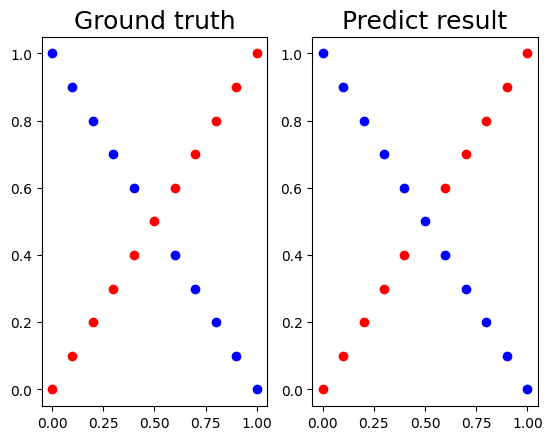

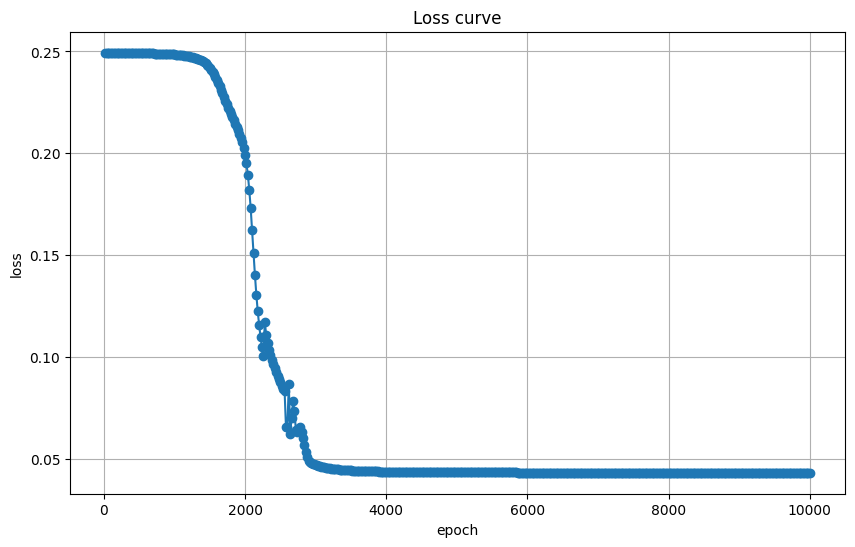

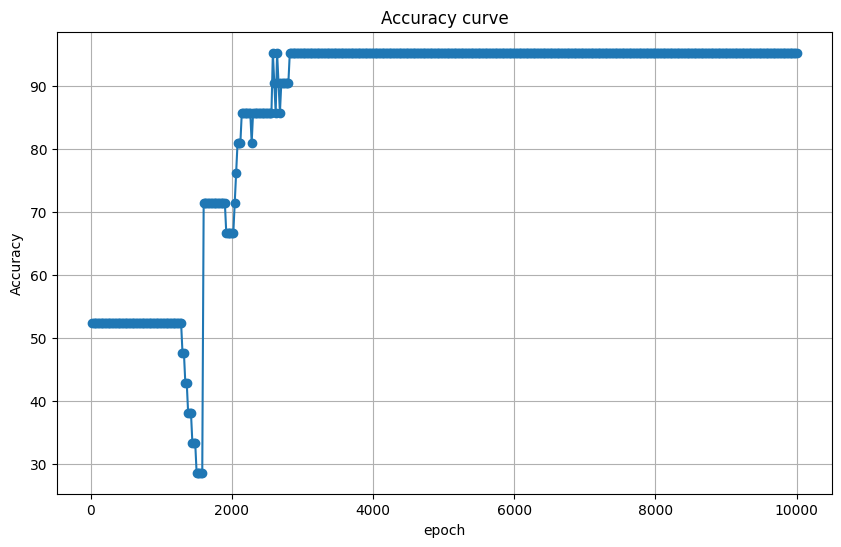

In [159]:
x,y = generate_XOR_easy()
m = model(memory_epoch=20)
m.clear()
m.add_layer(2,4,sigmoid,derivative_sigmoid)
m.add_layer(4,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(10000,x,y,0.1,1000,batch=32)
pred_y = m.testing(x,y,show_info=True)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

# no optimizer , only SGD, batch = 256, learning_rate = 0.1, epoch = 10k, 2,4,4,1 all sigmoid

---START TRAINING---
epoch     1000: loss : 0.0165096744
epoch     2000: loss : 0.0133546540
epoch     3000: loss : 0.0120894287
epoch     4000: loss : 0.0098347713
epoch     5000: loss : 0.0030836749
epoch     6000: loss : 0.0041756704
epoch     7000: loss : 0.0099000349
epoch     8000: loss : 0.0003910581
epoch     9000: loss : 0.0001986959
epoch    10000: loss : 0.0001308822
spent: 1.7433433532714844s
---FINISH TRAINING---
Iter   0 |    Ground truth: 0.000000 |   prediction: 0.000007 |
Iter   1 |    Ground truth: 0.000000 |   prediction: 0.000007 |
Iter   2 |    Ground truth: 0.000000 |   prediction: 0.000007 |
Iter   3 |    Ground truth: 1.000000 |   prediction: 0.999923 |
Iter   4 |    Ground truth: 0.000000 |   prediction: 0.000053 |
Iter   5 |    Ground truth: 1.000000 |   prediction: 0.992149 |
Iter   6 |    Ground truth: 0.000000 |   prediction: 0.000007 |
Iter   7 |    Ground truth: 1.000000 |   prediction: 0.999987 |
Iter   8 |    Ground truth: 1.000000 |   prediction: 0.999

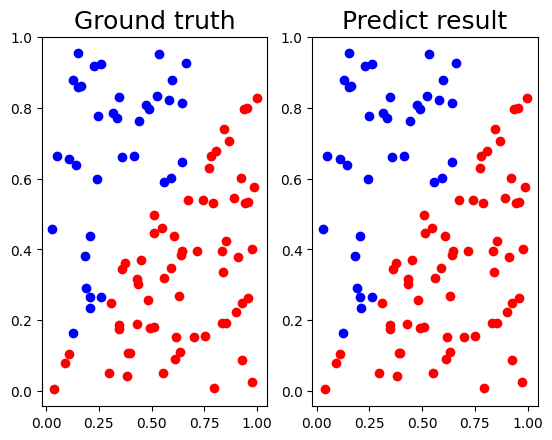

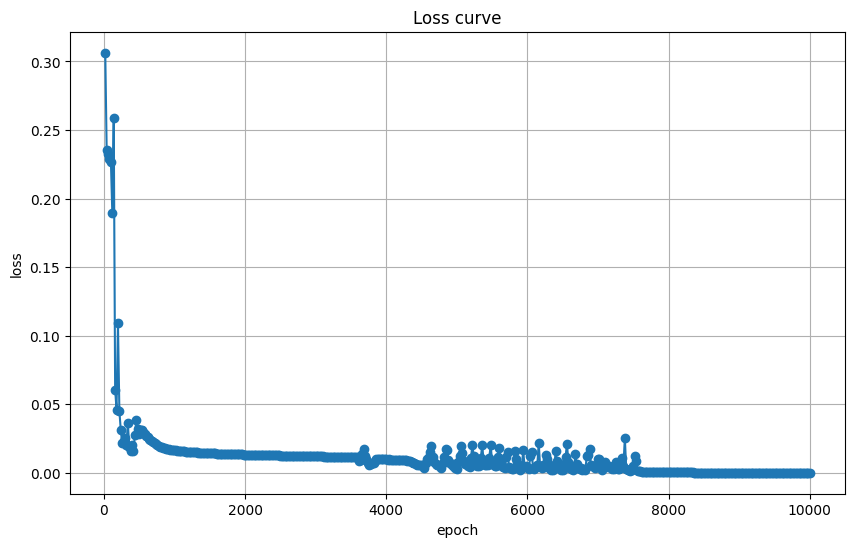

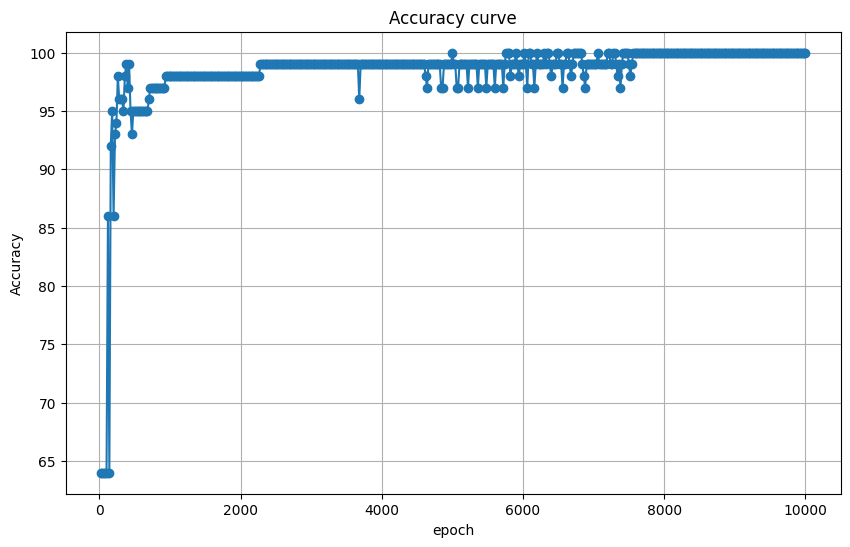

In [160]:
x,y = generate_linear(n = 100)
m = model(memory_epoch=20)
m.clear()
m.add_layer(2,4,sigmoid,derivative_sigmoid)
m.add_layer(4,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(10000,x,y,0.1,1000,batch=256)
pred_y = m.testing(x,y,show_info=True)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch     1000: loss : 0.2493228528
epoch     2000: loss : 0.2488068536
epoch     3000: loss : 0.2291101695
epoch     4000: loss : 0.0777789849
epoch     5000: loss : 0.0441914597
epoch     6000: loss : 0.0435886130
epoch     7000: loss : 0.0434538671
epoch     8000: loss : 0.0433994892
epoch     9000: loss : 0.0433710116
epoch    10000: loss : 0.0433537579
spent: 0.8838541507720947s
---FINISH TRAINING---
Iter   0 |    Ground truth: 0.000000 |   prediction: 0.000681 |
Iter   1 |    Ground truth: 1.000000 |   prediction: 0.907954 |
Iter   2 |    Ground truth: 0.000000 |   prediction: 0.000641 |
Iter   3 |    Ground truth: 1.000000 |   prediction: 0.907955 |
Iter   4 |    Ground truth: 0.000000 |   prediction: 0.000611 |
Iter   5 |    Ground truth: 1.000000 |   prediction: 0.907955 |
Iter   6 |    Ground truth: 0.000000 |   prediction: 0.000766 |
Iter   7 |    Ground truth: 1.000000 |   prediction: 0.907955 |
Iter   8 |    Ground truth: 0.000000 |   prediction: 0.024

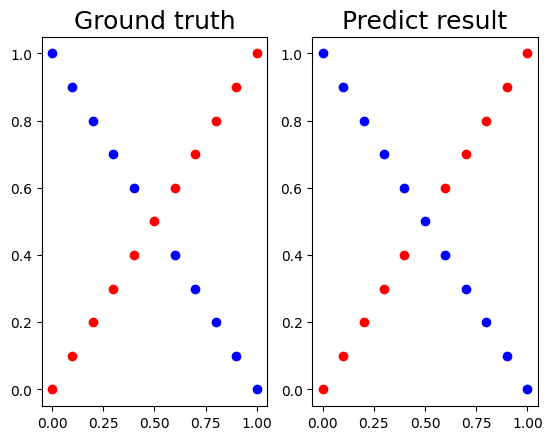

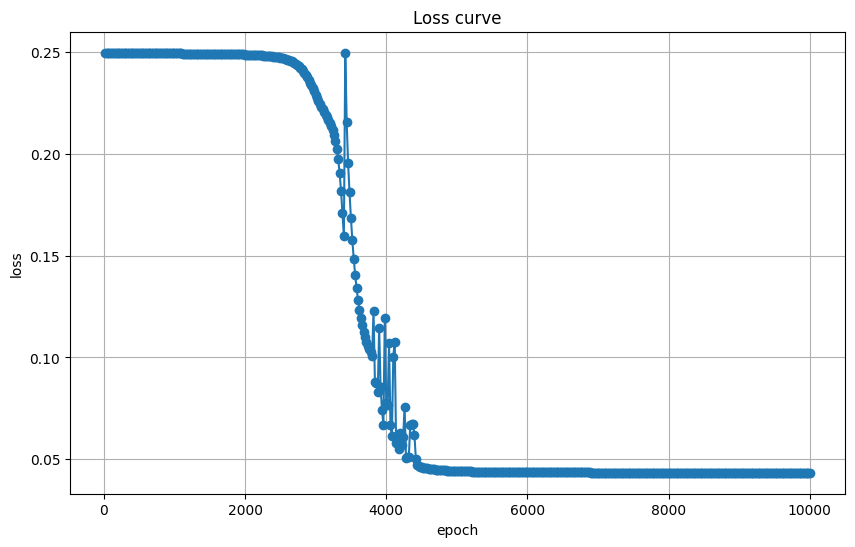

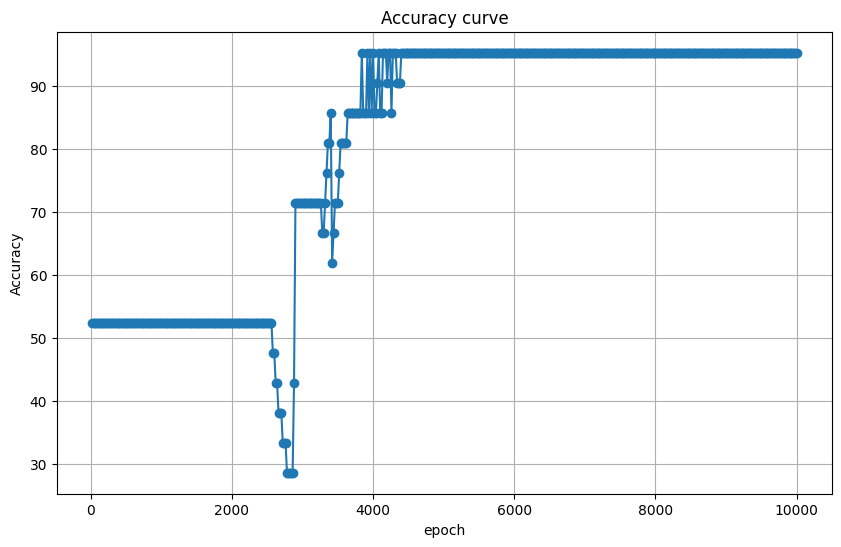

In [164]:
x,y = generate_XOR_easy()
m = model(memory_epoch=20)
m.clear()
m.add_layer(2,4,sigmoid,derivative_sigmoid)
m.add_layer(4,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(10000,x,y,0.1,1000,batch=256)
pred_y = m.testing(x,y,show_info=True)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

# no optimizer , only SGD, batch = 32, learning_rate = 0.001, epoch = 10k, 2,4,4,1 all sigmoid

---START TRAINING---
epoch     1000: loss : 0.2493466112
epoch     2000: loss : 0.2492566579
epoch     3000: loss : 0.2491205025
epoch     4000: loss : 0.2488982489
epoch     5000: loss : 0.2484926869
epoch     6000: loss : 0.2476104307
epoch     7000: loss : 0.2450217673
epoch     8000: loss : 0.2326173269
epoch     9000: loss : 0.1529540925
epoch    10000: loss : 0.0637364654
spent: 3.678274154663086s
---FINISH TRAINING---
Iter   0 |    Ground truth: 1.000000 |   prediction: 0.448613 |
Iter   1 |    Ground truth: 0.000000 |   prediction: 0.129603 |
Iter   2 |    Ground truth: 0.000000 |   prediction: 0.152898 |
Iter   3 |    Ground truth: 1.000000 |   prediction: 0.804449 |
Iter   4 |    Ground truth: 1.000000 |   prediction: 0.707990 |
Iter   5 |    Ground truth: 0.000000 |   prediction: 0.360320 |
Iter   6 |    Ground truth: 0.000000 |   prediction: 0.235400 |
Iter   7 |    Ground truth: 1.000000 |   prediction: 0.799039 |
Iter   8 |    Ground truth: 0.000000 |   prediction: 0.1456

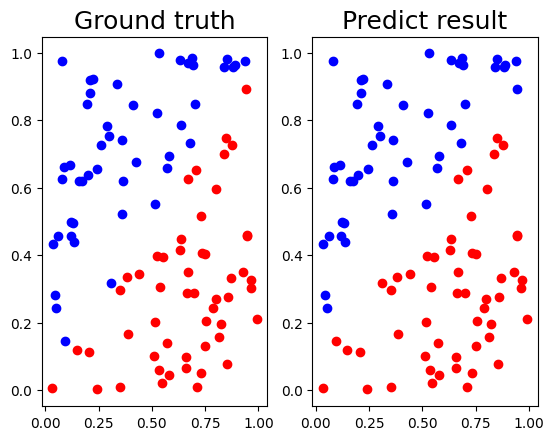

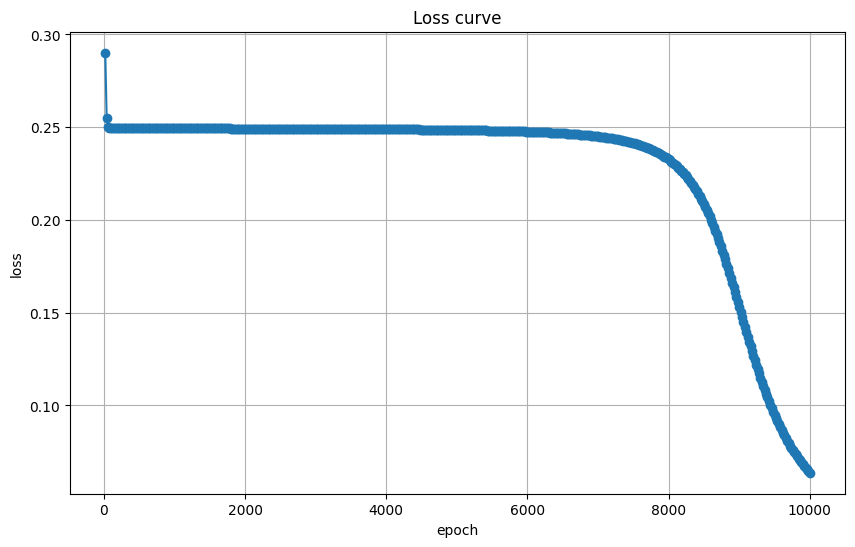

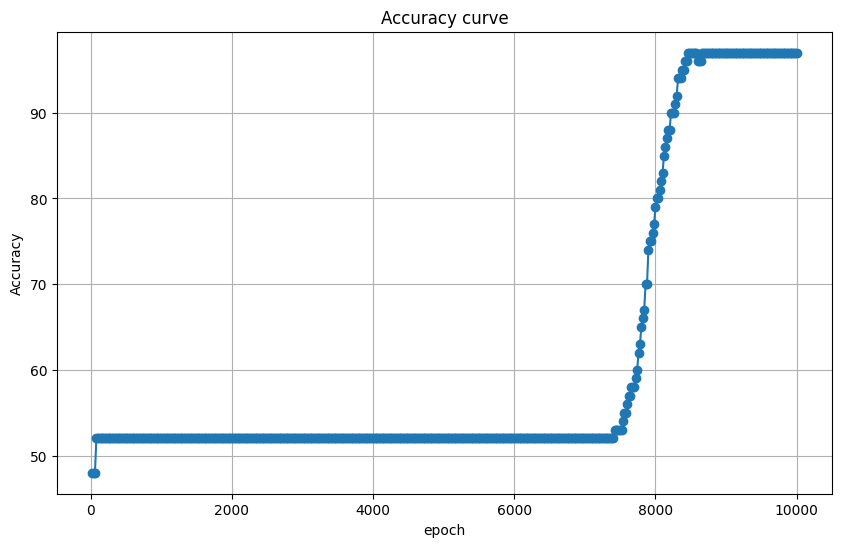

In [165]:
x,y = generate_linear(n = 100)
m = model(memory_epoch=20)
m.clear()
m.add_layer(2,4,sigmoid,derivative_sigmoid)
m.add_layer(4,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(10000,x,y,0.001,1000,batch=32)
pred_y = m.testing(x,y,show_info=True)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch     1000: loss : 0.2495185016
epoch     2000: loss : 0.2495149425
epoch     3000: loss : 0.2495114096
epoch     4000: loss : 0.2495079003
epoch     5000: loss : 0.2495044128
epoch     6000: loss : 0.2495009455
epoch     7000: loss : 0.2494974968
epoch     8000: loss : 0.2494940649
epoch     9000: loss : 0.2494906483
epoch    10000: loss : 0.2494872454
spent: 0.8677325248718262s
---FINISH TRAINING---
Iter   0 |    Ground truth: 0.000000 |   prediction: 0.478059 |
Iter   1 |    Ground truth: 1.000000 |   prediction: 0.476940 |
Iter   2 |    Ground truth: 0.000000 |   prediction: 0.477729 |
Iter   3 |    Ground truth: 1.000000 |   prediction: 0.476881 |
Iter   4 |    Ground truth: 0.000000 |   prediction: 0.477424 |
Iter   5 |    Ground truth: 1.000000 |   prediction: 0.476824 |
Iter   6 |    Ground truth: 0.000000 |   prediction: 0.477145 |
Iter   7 |    Ground truth: 1.000000 |   prediction: 0.476768 |
Iter   8 |    Ground truth: 0.000000 |   prediction: 0.476

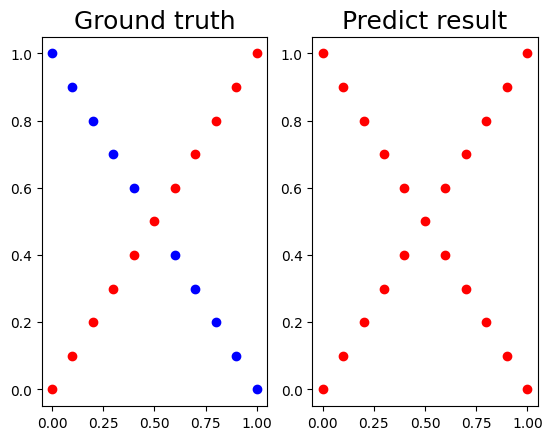

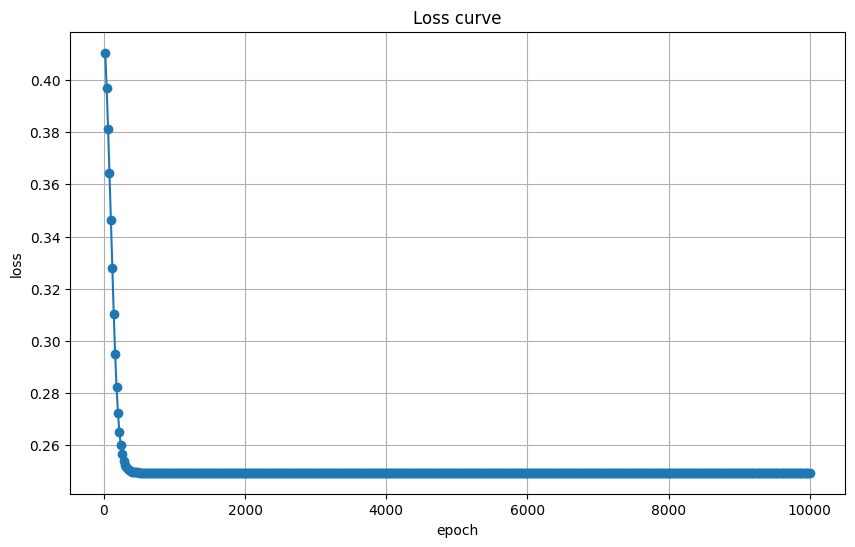

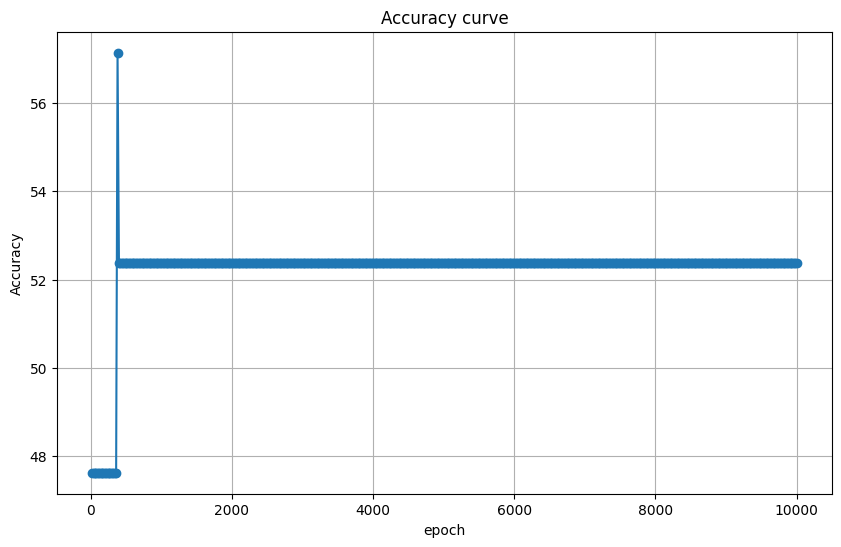

In [170]:
x,y = generate_XOR_easy()
m = model(memory_epoch=20)
m.clear()
m.add_layer(2,4,sigmoid,derivative_sigmoid)
m.add_layer(4,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(10000,x,y,0.001,1000,batch=32)
pred_y = m.testing(x,y,show_info=True)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

# no optimizer , only SGD, batch = 32, learning_rate = 0.1, epoch = 10k, 2,8,8,1 all sigmoid

---START TRAINING---
epoch     1000: loss : 0.0075868540
epoch     2000: loss : 0.0009450248
epoch     3000: loss : 0.0001706738
epoch     4000: loss : 0.0000878456
epoch     5000: loss : 0.0000589636
epoch     6000: loss : 0.0000445133
epoch     7000: loss : 0.0000357681
epoch     8000: loss : 0.0000298923
epoch     9000: loss : 0.0000256569
epoch    10000: loss : 0.0000224584
spent: 3.8104543685913086s
---FINISH TRAINING---
Iter   0 |    Ground truth: 1.000000 |   prediction: 0.999991 |
Iter   1 |    Ground truth: 1.000000 |   prediction: 0.999942 |
Iter   2 |    Ground truth: 0.000000 |   prediction: 0.000007 |
Iter   3 |    Ground truth: 1.000000 |   prediction: 0.999996 |
Iter   4 |    Ground truth: 1.000000 |   prediction: 0.999997 |
Iter   5 |    Ground truth: 0.000000 |   prediction: 0.000006 |
Iter   6 |    Ground truth: 1.000000 |   prediction: 0.999996 |
Iter   7 |    Ground truth: 0.000000 |   prediction: 0.000004 |
Iter   8 |    Ground truth: 1.000000 |   prediction: 0.999

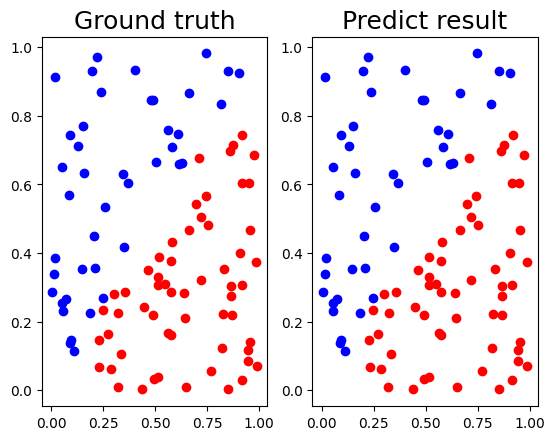

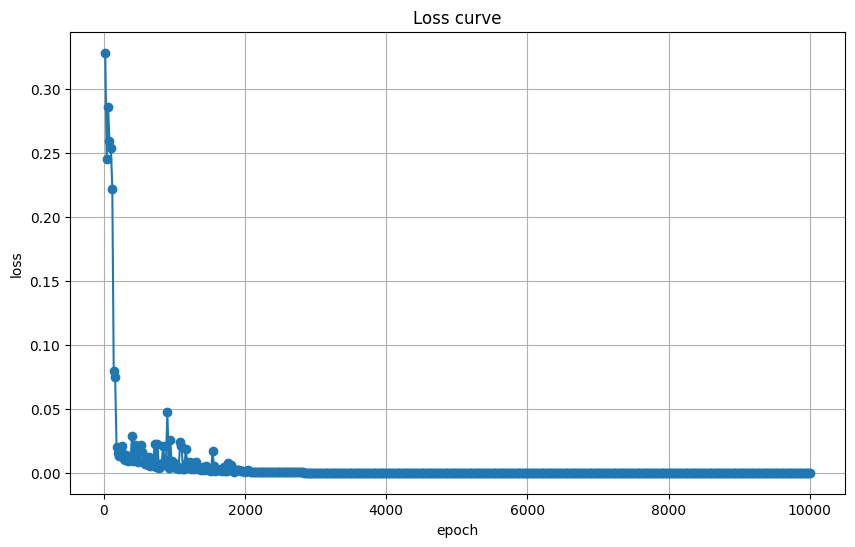

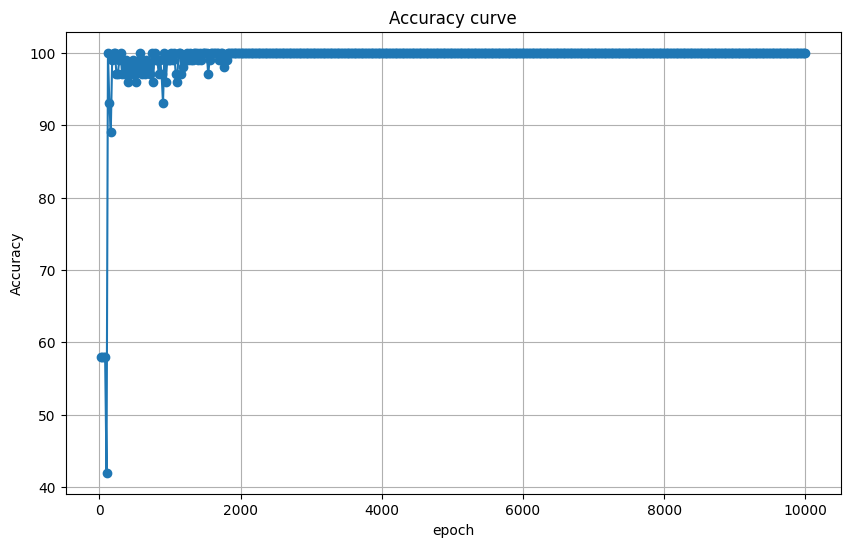

In [171]:
x,y = generate_linear(n = 100)
m = model(memory_epoch=20)
m.clear()
m.add_layer(2,8,sigmoid,derivative_sigmoid)
m.add_layer(8,8,sigmoid,derivative_sigmoid)
m.add_layer(8,1,sigmoid,derivative_sigmoid)
m.training(10000,x,y,0.1,1000,batch=32)
pred_y = m.testing(x,y,show_info=True)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch     1000: loss : 0.2500396203
epoch     2000: loss : 0.1810731834
epoch     3000: loss : 0.0176151838
epoch     4000: loss : 0.0020716506
epoch     5000: loss : 0.0007890739
epoch     6000: loss : 0.0004377849
epoch     7000: loss : 0.0002896388
epoch     8000: loss : 0.0002114016
epoch     9000: loss : 0.0001641316
epoch    10000: loss : 0.0001329178
spent: 0.9766736030578613s
---FINISH TRAINING---
Iter   0 |    Ground truth: 0.000000 |   prediction: 0.000200 |
Iter   1 |    Ground truth: 1.000000 |   prediction: 0.999950 |
Iter   2 |    Ground truth: 0.000000 |   prediction: 0.000169 |
Iter   3 |    Ground truth: 1.000000 |   prediction: 0.999942 |
Iter   4 |    Ground truth: 0.000000 |   prediction: 0.000181 |
Iter   5 |    Ground truth: 1.000000 |   prediction: 0.999925 |
Iter   6 |    Ground truth: 0.000000 |   prediction: 0.000380 |
Iter   7 |    Ground truth: 1.000000 |   prediction: 0.999813 |
Iter   8 |    Ground truth: 0.000000 |   prediction: 0.006

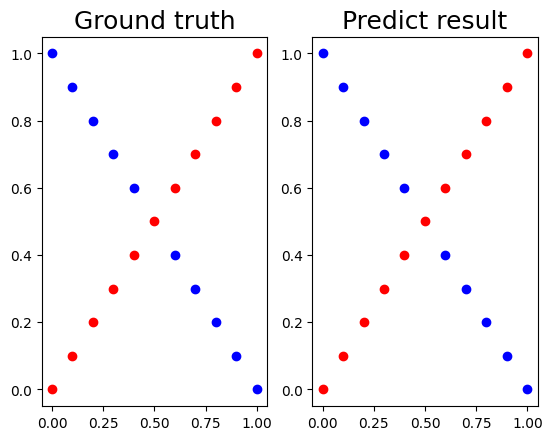

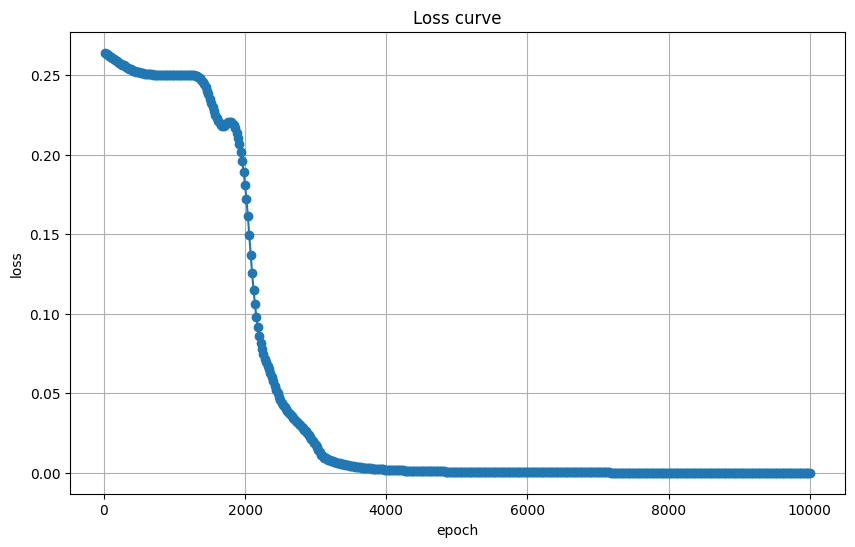

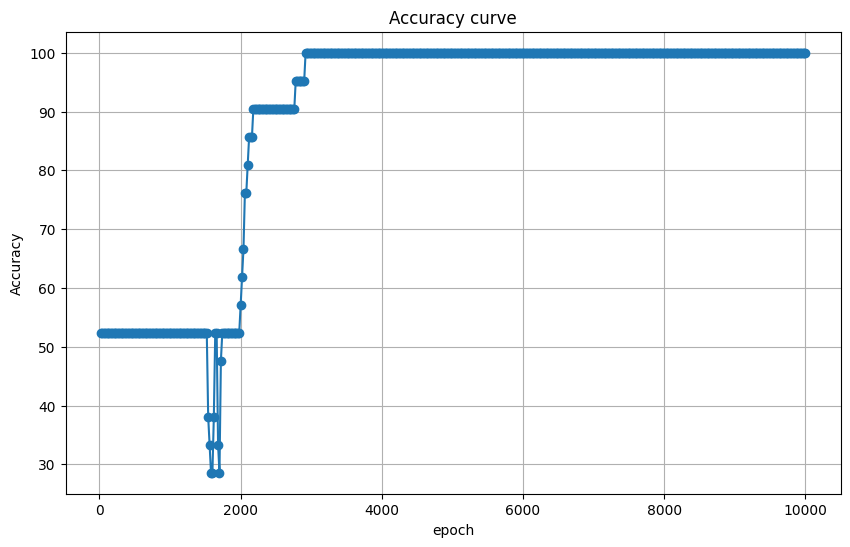

In [172]:
x,y = generate_XOR_easy()
m = model(memory_epoch=20)
m.clear()
m.add_layer(2,8,sigmoid,derivative_sigmoid)
m.add_layer(8,8,sigmoid,derivative_sigmoid)
m.add_layer(8,1,sigmoid,derivative_sigmoid)
m.training(10000,x,y,0.1,1000,batch=32)
pred_y = m.testing(x,y,show_info=True)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

# no optimizer , only SGD, batch = 32, learning_rate = 0.1, epoch = 10k, 2,4,4,1 all ReLU,ReLU,Sigmod

---START TRAINING---
epoch     1000: loss : 0.0000504649
epoch     2000: loss : 0.0000125865
epoch     3000: loss : 0.0000068719
epoch     4000: loss : 0.0000046453
epoch     5000: loss : 0.0000034771
epoch     6000: loss : 0.0000027638
epoch     7000: loss : 0.0000022851
epoch     8000: loss : 0.0000019424
epoch     9000: loss : 0.0000016866
epoch    10000: loss : 0.0000014866
spent: 4.069463729858398s
---FINISH TRAINING---
Iter   0 |    Ground truth: 1.000000 |   prediction: 0.999400 |
Iter   1 |    Ground truth: 0.000000 |   prediction: 0.000000 |
Iter   2 |    Ground truth: 1.000000 |   prediction: 0.999400 |
Iter   3 |    Ground truth: 0.000000 |   prediction: 0.000000 |
Iter   4 |    Ground truth: 0.000000 |   prediction: 0.000000 |
Iter   5 |    Ground truth: 0.000000 |   prediction: 0.000000 |
Iter   6 |    Ground truth: 1.000000 |   prediction: 0.999400 |
Iter   7 |    Ground truth: 1.000000 |   prediction: 0.999400 |
Iter   8 |    Ground truth: 1.000000 |   prediction: 0.9994

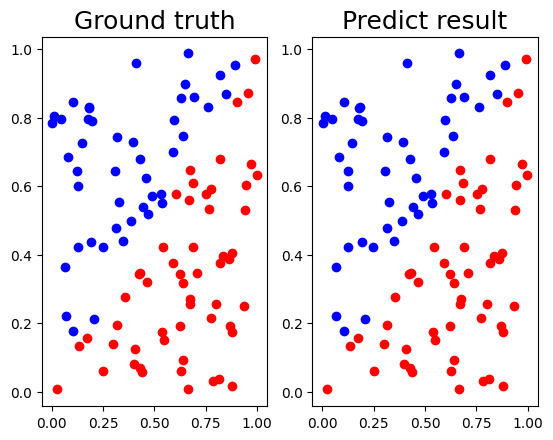

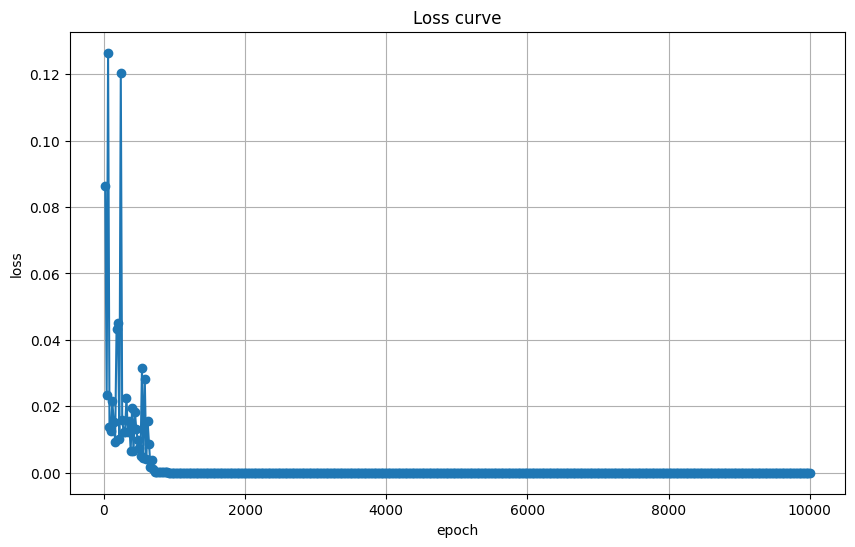

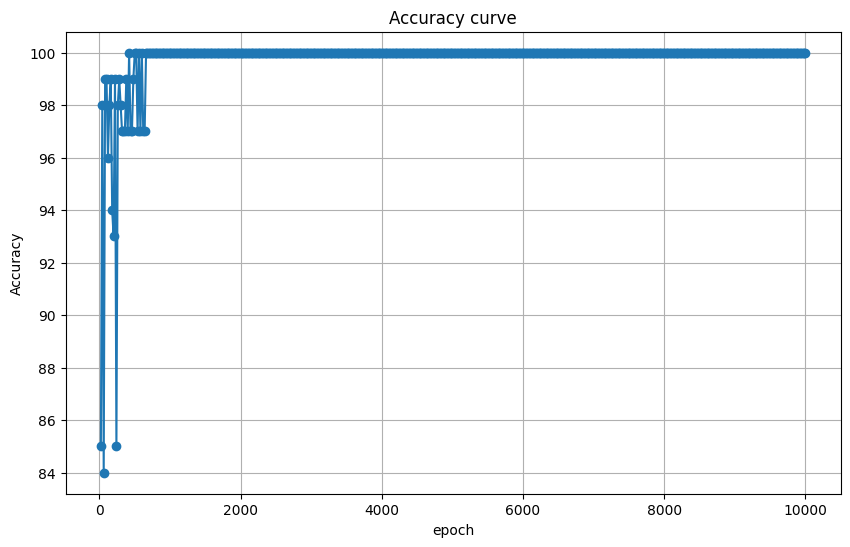

In [173]:
x,y = generate_linear(n = 100)
m = model(memory_epoch=20)
m.clear()
m.add_layer(2,4,relu,derivative_relu)
m.add_layer(4,4,relu,derivative_relu)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(10000,x,y,0.1,1000,batch=32)
pred_y = m.testing(x,y,show_info=True)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch     1000: loss : 0.0433059546
epoch     2000: loss : 0.0432979897
epoch     3000: loss : 0.0432945570
epoch     4000: loss : 0.0432944942
epoch     5000: loss : 0.0432930391
epoch     6000: loss : 0.0432927944
epoch     7000: loss : 0.0432951611
epoch     8000: loss : 0.0432922964
epoch     9000: loss : 0.0432921912
epoch    10000: loss : 0.0432917886
spent: 0.9683957099914551s
---FINISH TRAINING---
Iter   0 |    Ground truth: 0.000000 |   prediction: 0.000919 |
Iter   1 |    Ground truth: 1.000000 |   prediction: 0.909045 |
Iter   2 |    Ground truth: 0.000000 |   prediction: 0.000919 |
Iter   3 |    Ground truth: 1.000000 |   prediction: 0.909045 |
Iter   4 |    Ground truth: 0.000000 |   prediction: 0.000919 |
Iter   5 |    Ground truth: 1.000000 |   prediction: 0.909045 |
Iter   6 |    Ground truth: 0.000000 |   prediction: 0.000919 |
Iter   7 |    Ground truth: 1.000000 |   prediction: 0.909045 |
Iter   8 |    Ground truth: 0.000000 |   prediction: 0.004

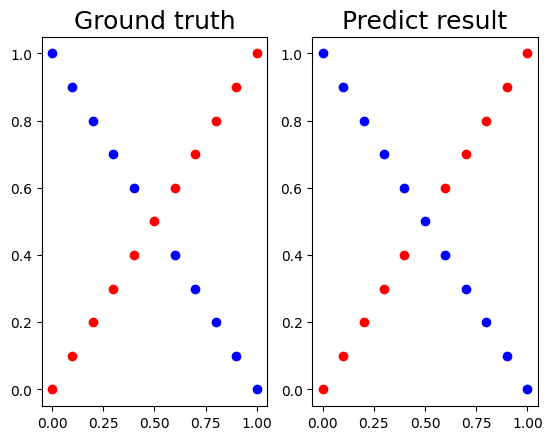

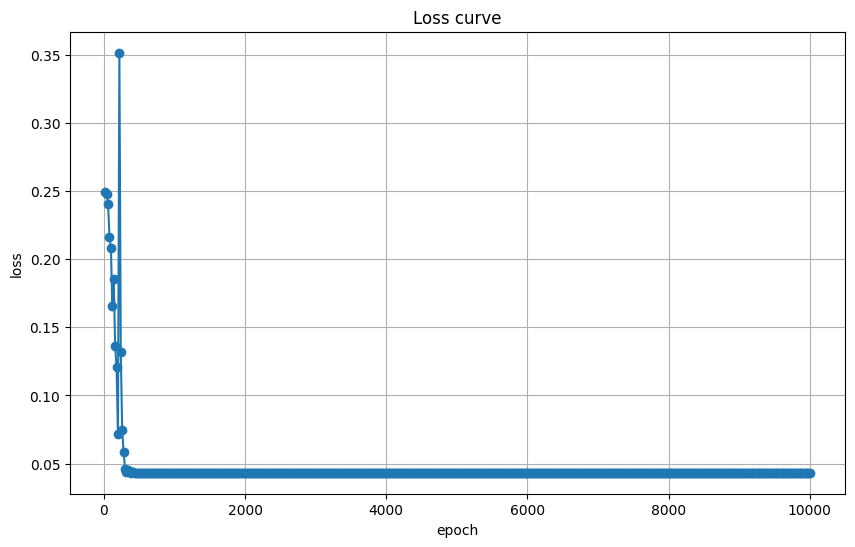

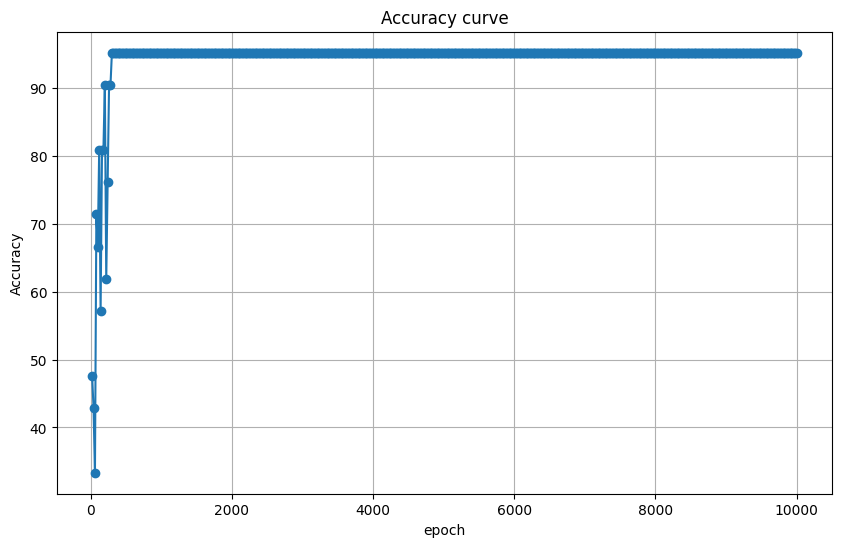

In [181]:
x,y = generate_XOR_easy()
m = model(memory_epoch=20)
m.clear()
m.add_layer(2,4,relu,derivative_relu)
m.add_layer(4,4,relu,derivative_relu)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(10000,x,y,0.1,1000,batch=32)
pred_y = m.testing(x,y,show_info=True)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

# no optimizer , only SGD, batch = 32, learning_rate = 0.1, epoch = 10k, 2,4,4,1 no activation functions

---START TRAINING---
epoch     1000: loss : 0.2545789661
epoch     2000: loss : 0.2543662980
epoch     3000: loss : 0.2541879990
epoch     4000: loss : 0.2540170222
epoch     5000: loss : 0.2538529250
epoch     6000: loss : 0.2536954212
epoch     7000: loss : 0.2535442403
epoch     8000: loss : 0.2533991249
epoch     9000: loss : 0.2532598299
epoch    10000: loss : 0.2531261220
spent: 0.7433390617370605s
---FINISH TRAINING---
Iter   0 |    Ground truth: 0.000000 |   prediction: 0.619733 |
Iter   1 |    Ground truth: 1.000000 |   prediction: 0.483830 |
Iter   2 |    Ground truth: 0.000000 |   prediction: 0.594077 |
Iter   3 |    Ground truth: 1.000000 |   prediction: 0.485354 |
Iter   4 |    Ground truth: 0.000000 |   prediction: 0.568420 |
Iter   5 |    Ground truth: 1.000000 |   prediction: 0.486879 |
Iter   6 |    Ground truth: 0.000000 |   prediction: 0.542764 |
Iter   7 |    Ground truth: 1.000000 |   prediction: 0.488403 |
Iter   8 |    Ground truth: 0.000000 |   prediction: 0.517

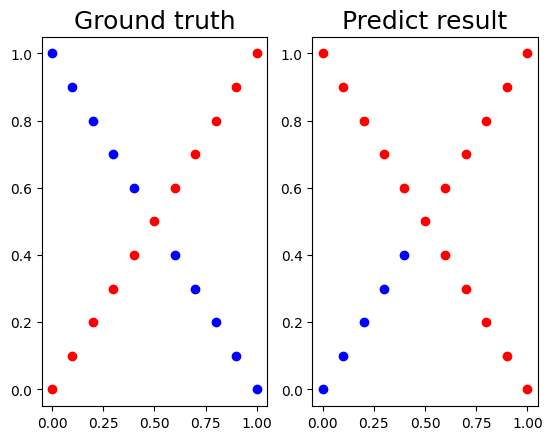

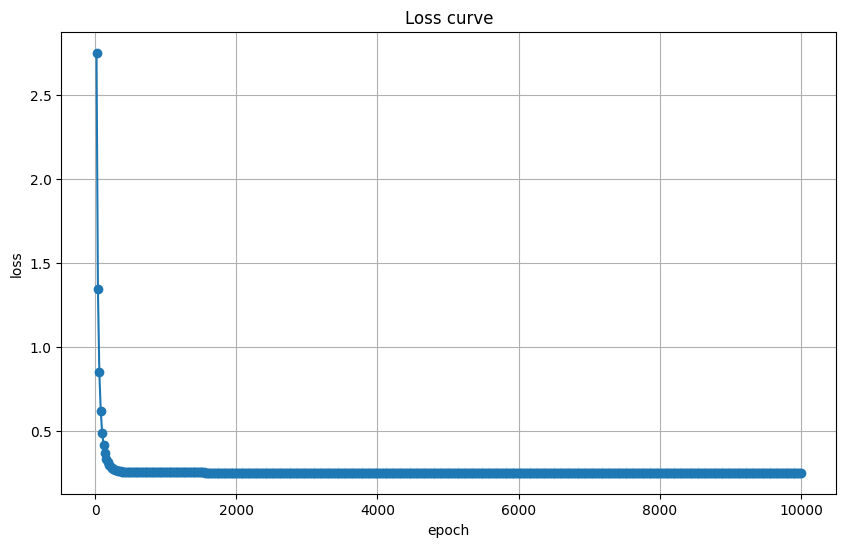

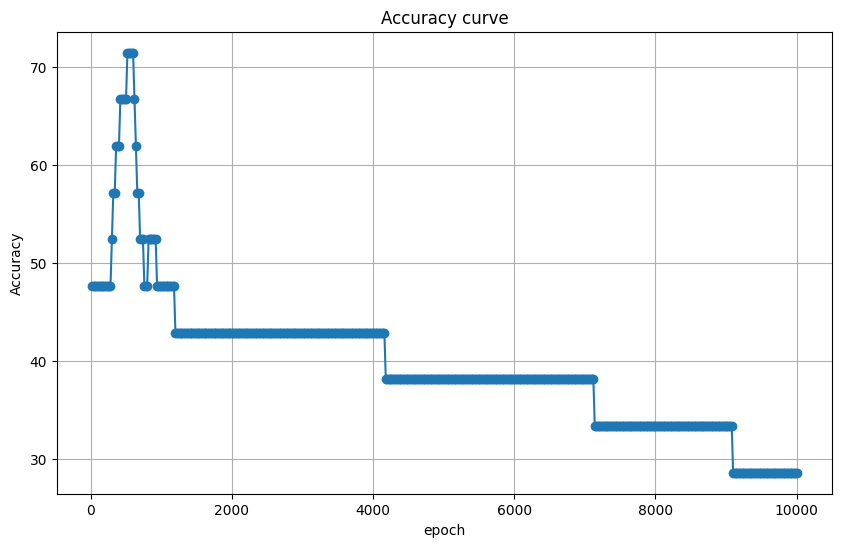

In [261]:
x,y = generate_XOR_easy()
m = model(memory_epoch=20)
m.clear()
m.add_layer(2,4)
m.add_layer(4,4)
m.add_layer(4,1)
m.training(10000,x,y,0.00001,1000,batch=32)
pred_y = m.testing(x,y,show_info=True)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch     1000: loss : 0.2155863554
epoch     2000: loss : 0.2089800308
epoch     3000: loss : 0.2020457350
epoch     4000: loss : 0.1942884402
epoch     5000: loss : 0.1851128308
epoch     6000: loss : 0.1738070957
epoch     7000: loss : 0.1596788711
epoch     8000: loss : 0.1428130919
epoch     9000: loss : 0.1249810990
epoch    10000: loss : 0.1095959436
spent: 2.901160717010498s
---FINISH TRAINING---
Iter   0 |    Ground truth: 0.000000 |   prediction: 0.543818 |
Iter   1 |    Ground truth: 0.000000 |   prediction: 0.132900 |
Iter   2 |    Ground truth: 0.000000 |   prediction: 0.041377 |
Iter   3 |    Ground truth: 0.000000 |   prediction: 0.141744 |
Iter   4 |    Ground truth: 1.000000 |   prediction: 0.747050 |
Iter   5 |    Ground truth: 1.000000 |   prediction: 0.888372 |
Iter   6 |    Ground truth: 1.000000 |   prediction: 0.708583 |
Iter   7 |    Ground truth: 0.000000 |   prediction: 0.343214 |
Iter   8 |    Ground truth: 1.000000 |   prediction: 0.4778

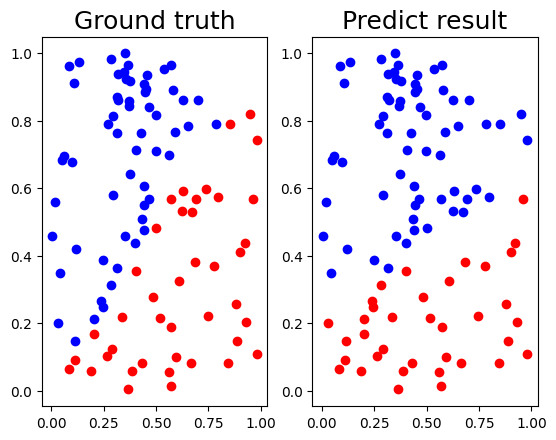

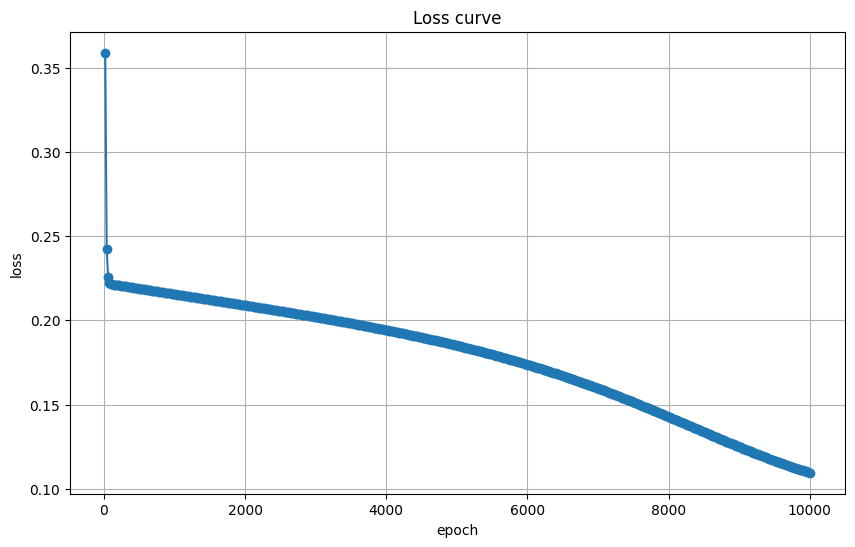

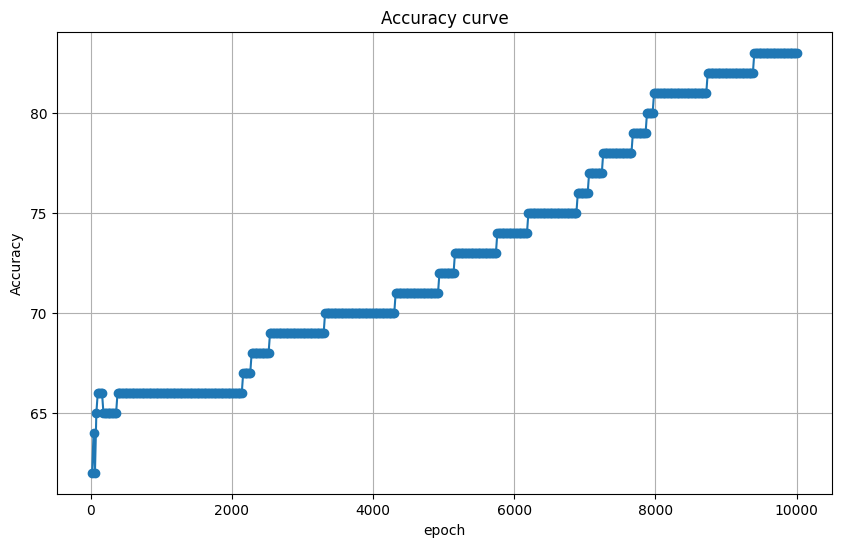

In [254]:
x,y = generate_linear(n = 100)
m = model(memory_epoch=20)
m.clear()
m.add_layer(2,4)
m.add_layer(4,4)
m.add_layer(4,1)
m.training(10000,x,y,0.00001,1000,batch=32)
pred_y = m.testing(x,y,show_info=True)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---


C:\Users\User\AppData\Local\Temp\ipykernel_22684\2797914413.py:110: RuntimeWarning: invalid value encountered in add
  self.a_output = self.activate_function(np.dot(feature,self.W) + self.b)


epoch     1000: loss : nan
epoch     2000: loss : nan
epoch     3000: loss : nan
epoch     4000: loss : nan
epoch     5000: loss : nan
epoch     6000: loss : nan
epoch     7000: loss : nan
epoch     8000: loss : nan
epoch     9000: loss : nan
epoch    10000: loss : nan
spent: 3.064518451690674s
---FINISH TRAINING---
Iter   0 |    Ground truth: 0.000000 |   prediction: nan |
Iter   1 |    Ground truth: 1.000000 |   prediction: nan |
Iter   2 |    Ground truth: 0.000000 |   prediction: nan |
Iter   3 |    Ground truth: 0.000000 |   prediction: nan |
Iter   4 |    Ground truth: 0.000000 |   prediction: nan |
Iter   5 |    Ground truth: 1.000000 |   prediction: nan |
Iter   6 |    Ground truth: 1.000000 |   prediction: nan |
Iter   7 |    Ground truth: 1.000000 |   prediction: nan |
Iter   8 |    Ground truth: 1.000000 |   prediction: nan |
Iter   9 |    Ground truth: 0.000000 |   prediction: nan |
Iter  10 |    Ground truth: 1.000000 |   prediction: nan |
Iter  11 |    Ground truth: 0.000

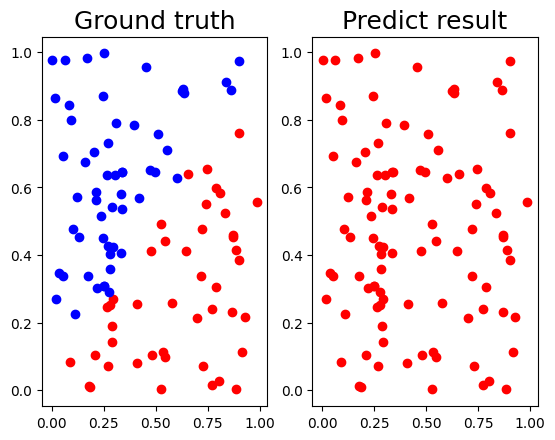

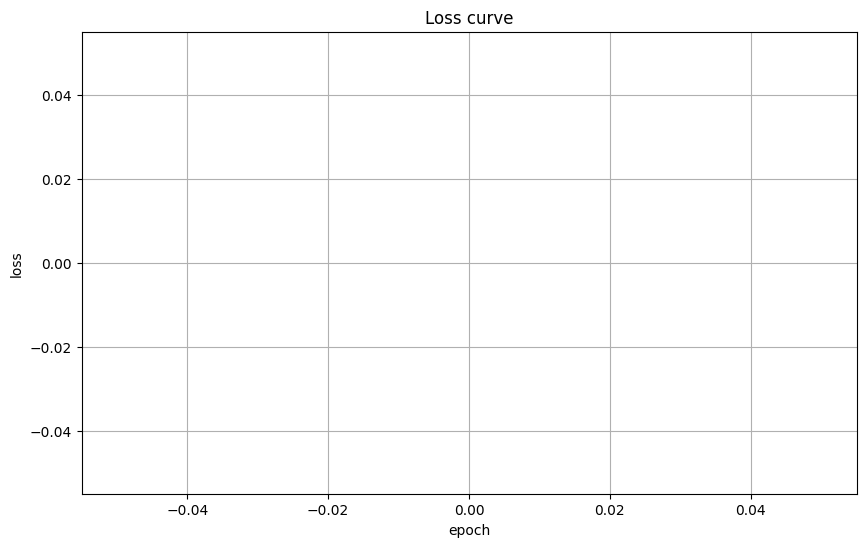

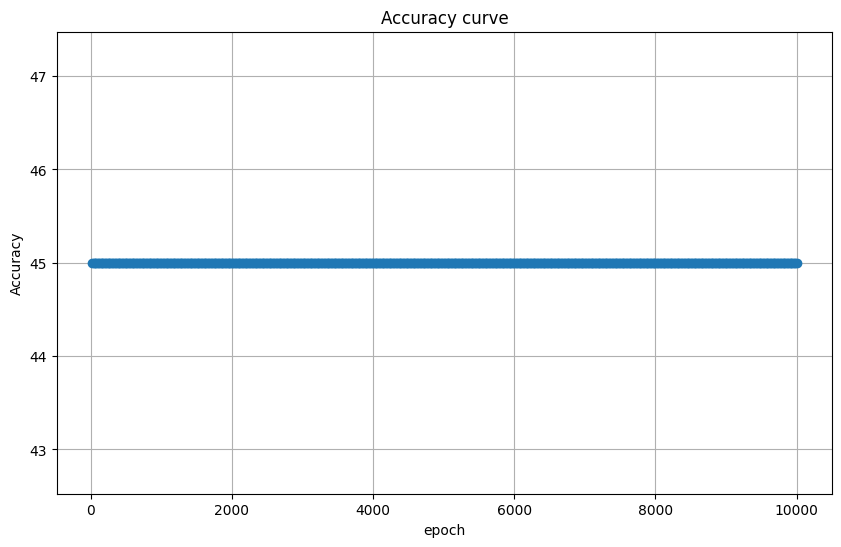

In [192]:
x,y = generate_linear(n = 100)
m = model(memory_epoch=20)
m.clear()
m.add_layer(2,4)
m.add_layer(4,4)
m.add_layer(4,1)
m.training(10000,x,y,0.1,1000,batch=32)
pred_y = m.testing(x,y,show_info=True)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch     1000: loss : nan
epoch     2000: loss : nan
epoch     3000: loss : nan
epoch     4000: loss : nan
epoch     5000: loss : nan
epoch     6000: loss : nan
epoch     7000: loss : nan
epoch     8000: loss : nan
epoch     9000: loss : nan
epoch    10000: loss : nan
spent: 0.7857785224914551s
---FINISH TRAINING---
Iter   0 |    Ground truth: 0.000000 |   prediction: nan |
Iter   1 |    Ground truth: 1.000000 |   prediction: nan |
Iter   2 |    Ground truth: 0.000000 |   prediction: nan |
Iter   3 |    Ground truth: 1.000000 |   prediction: nan |
Iter   4 |    Ground truth: 0.000000 |   prediction: nan |
Iter   5 |    Ground truth: 1.000000 |   prediction: nan |
Iter   6 |    Ground truth: 0.000000 |   prediction: nan |
Iter   7 |    Ground truth: 1.000000 |   prediction: nan |
Iter   8 |    Ground truth: 0.000000 |   prediction: nan |
Iter   9 |    Ground truth: 1.000000 |   prediction: nan |
Iter  10 |    Ground truth: 0.000000 |   prediction: nan |
Iter  11 | 

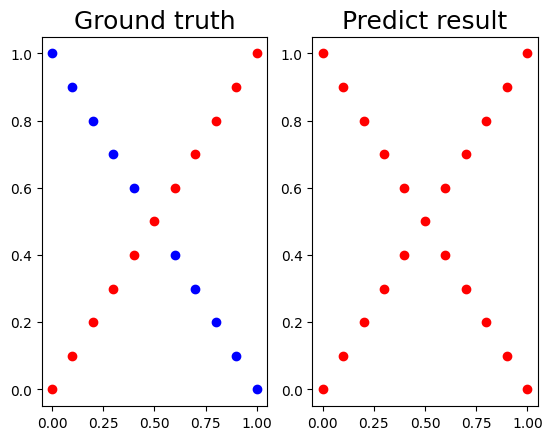

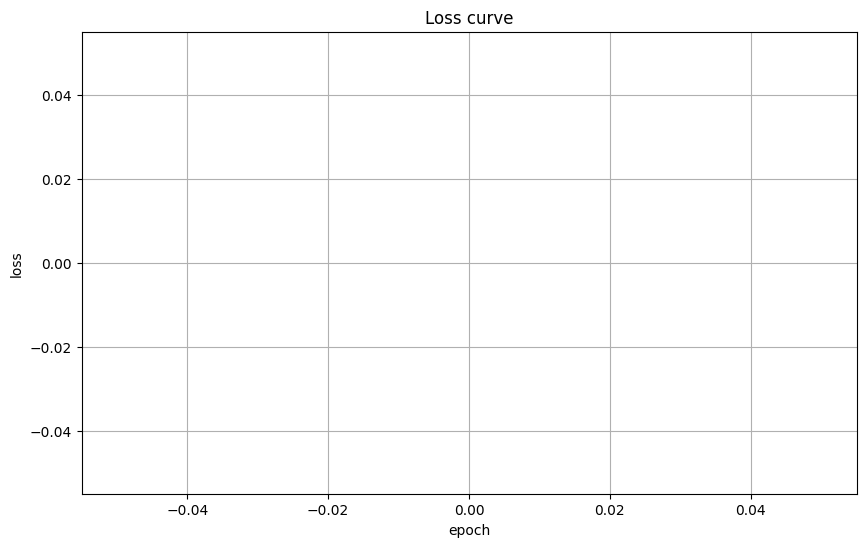

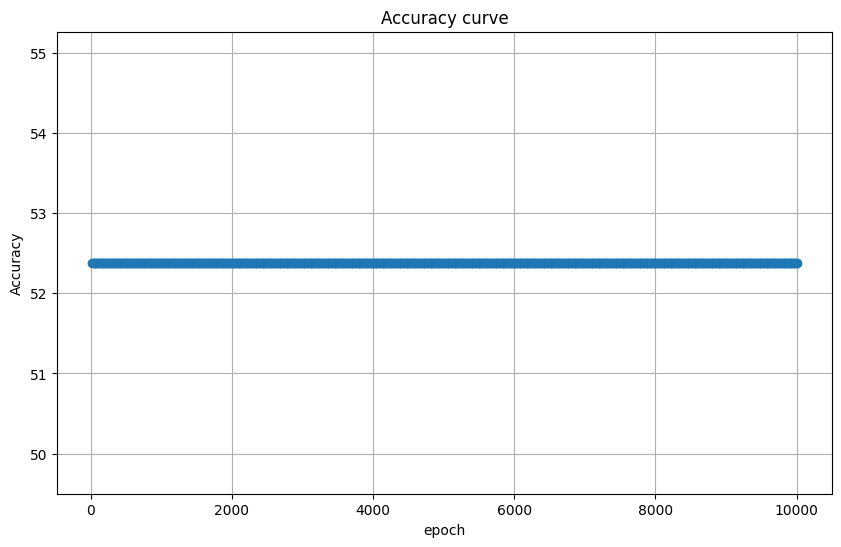

In [193]:
x,y = generate_XOR_easy()
m = model(memory_epoch=20)
m.clear()
m.add_layer(2,4)
m.add_layer(4,4)
m.add_layer(4,1)
m.training(10000,x,y,0.1,1000,batch=32)
pred_y = m.testing(x,y,show_info=True)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch     1000: loss : 0.4999999631
epoch     2000: loss : 0.4999999625
epoch     3000: loss : 0.4999999619
epoch     4000: loss : 0.4999999613
epoch     5000: loss : 0.4999999607
epoch     6000: loss : 0.4999999600
epoch     7000: loss : 0.4999999594
epoch     8000: loss : 0.4999999587
epoch     9000: loss : 0.4999999580
epoch    10000: loss : 0.4999999572
spent: 4.8385560512542725s
---FINISH TRAINING---
Iter   0 |    Ground truth: 1.000000 |   prediction: 1.000000 |
Iter   1 |    Ground truth: 0.000000 |   prediction: 1.000000 |
Iter   2 |    Ground truth: 0.000000 |   prediction: 1.000000 |
Iter   3 |    Ground truth: 1.000000 |   prediction: 1.000000 |
Iter   4 |    Ground truth: 1.000000 |   prediction: 1.000000 |
Iter   5 |    Ground truth: 1.000000 |   prediction: 1.000000 |
Iter   6 |    Ground truth: 1.000000 |   prediction: 1.000000 |
Iter   7 |    Ground truth: 0.000000 |   prediction: 1.000000 |
Iter   8 |    Ground truth: 0.000000 |   prediction: 1.000

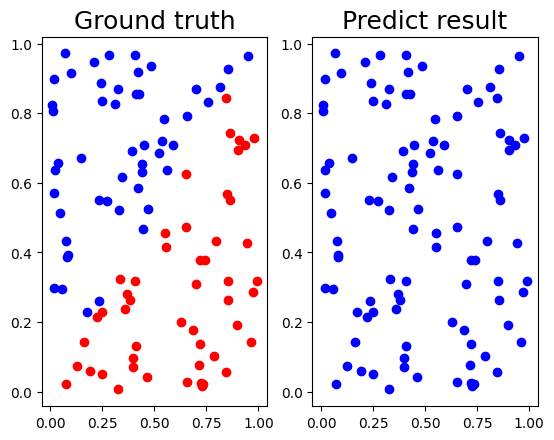

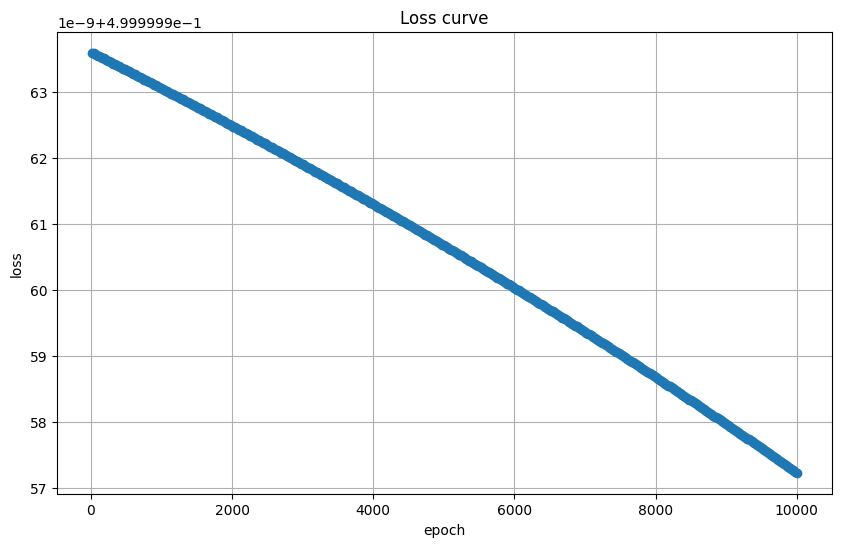

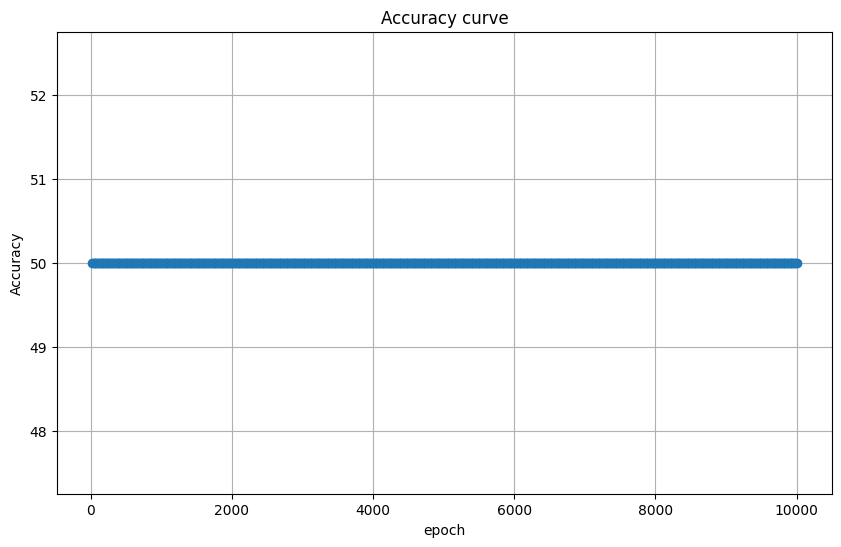

In [271]:
x,y = generate_linear(n = 100)
m = model(memory_epoch=20)
m.clear()
m.add_layer(2,40,sigmoid,derivative_sigmoid)
m.add_layer(40,40,sigmoid,derivative_sigmoid)
m.add_layer(40,1,sigmoid,derivative_sigmoid)
m.training(10000,x,y,0.1,1000,batch=32)
pred_y = m.testing(x,y,show_info=True)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch     1000: loss : 0.5238095219
epoch     2000: loss : 0.5238095219
epoch     3000: loss : 0.5238095219
epoch     4000: loss : 0.5238095219
epoch     5000: loss : 0.5238095219
epoch     6000: loss : 0.5238095219
epoch     7000: loss : 0.5238095219
epoch     8000: loss : 0.5238095219
epoch     9000: loss : 0.5238095219
epoch    10000: loss : 0.5238095219
spent: 1.254749059677124s
---FINISH TRAINING---
Iter   0 |    Ground truth: 0.000000 |   prediction: 1.000000 |
Iter   1 |    Ground truth: 1.000000 |   prediction: 1.000000 |
Iter   2 |    Ground truth: 0.000000 |   prediction: 1.000000 |
Iter   3 |    Ground truth: 1.000000 |   prediction: 1.000000 |
Iter   4 |    Ground truth: 0.000000 |   prediction: 1.000000 |
Iter   5 |    Ground truth: 1.000000 |   prediction: 1.000000 |
Iter   6 |    Ground truth: 0.000000 |   prediction: 1.000000 |
Iter   7 |    Ground truth: 1.000000 |   prediction: 1.000000 |
Iter   8 |    Ground truth: 0.000000 |   prediction: 1.0000

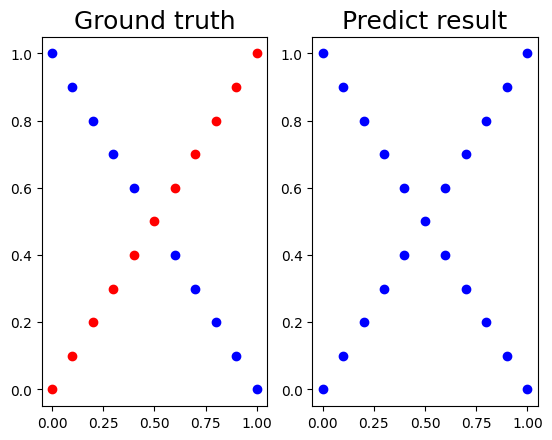

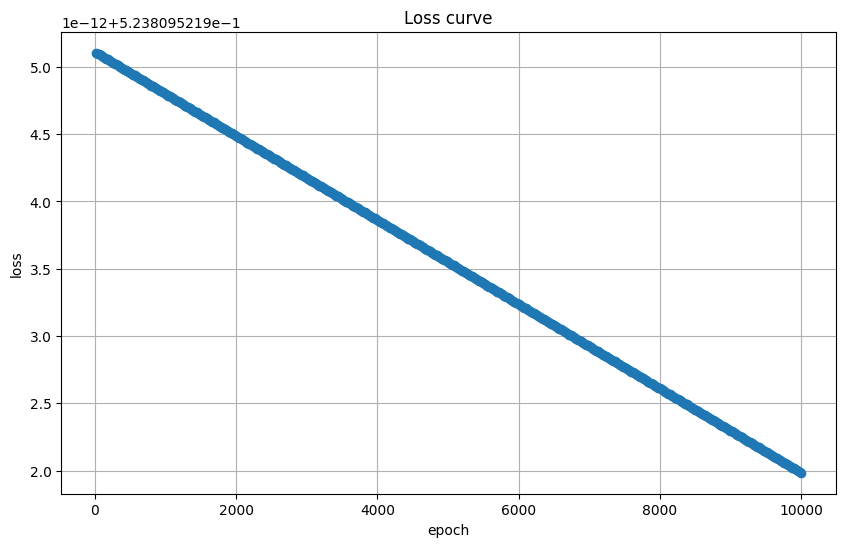

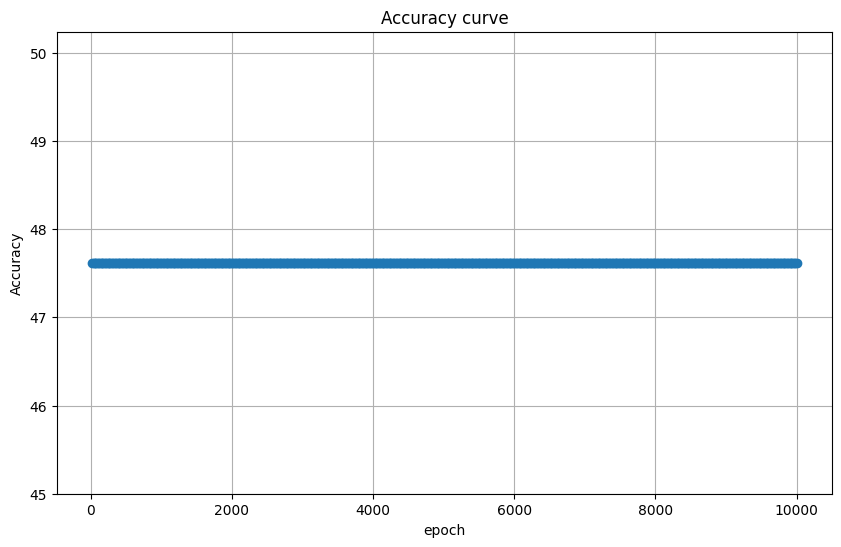

In [272]:
x,y = generate_XOR_easy()
m = model(memory_epoch=20)
m.clear()
m.add_layer(2,40,sigmoid,derivative_sigmoid)
m.add_layer(40,40,sigmoid,derivative_sigmoid)
m.add_layer(40,1,sigmoid,derivative_sigmoid)
m.training(10000,x,y,0.1,1000,batch=32)
pred_y = m.testing(x,y,show_info=True)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

epoch 1000: loss : 0.2379481364 accuracy=67.00%
epoch 2000: loss : 0.1016292974 accuracy=87.00%
epoch 3000: loss : 0.0779140115 accuracy=90.00%
epoch 4000: loss : 0.0624559874 accuracy=93.00%
epoch 5000: loss : 0.0312257792 accuracy=97.00%
epoch 6000: loss : 0.0145165113 accuracy=99.50%
epoch 7000: loss : 0.0083701158 accuracy=100.00%
last accuracy=100.00%
loss=0.0084 accuracy=100.00%


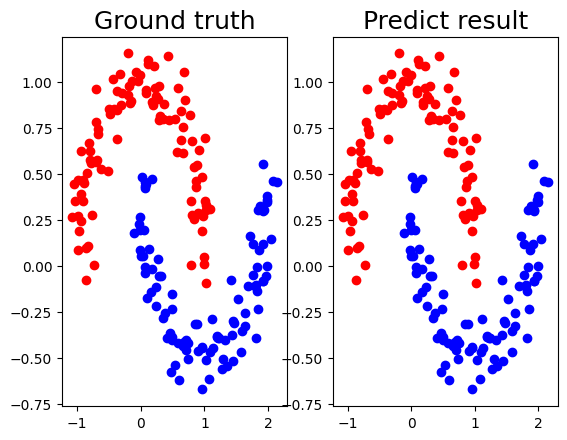

In [111]:
#x,y = generate_linear(n = 1000)
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
x,y= generate_XOR_hard_2()
x = moon_x
y = moon_y
m = model(16)
m.clear()
m.set_optimizer(Momentum(0.9))
m.add_layer(2,7,relu,derivative_relu)
m.add_layer(7,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(10000,x,y,0.001,1000,batch=16)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))

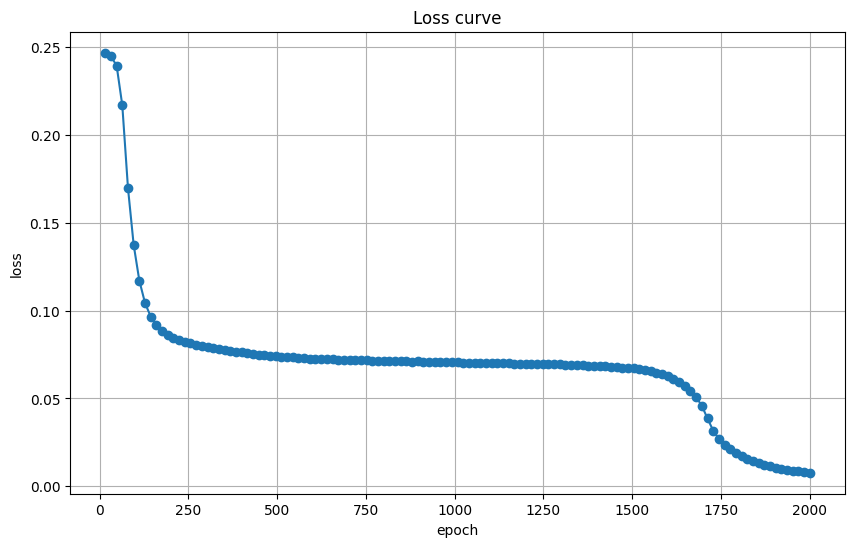

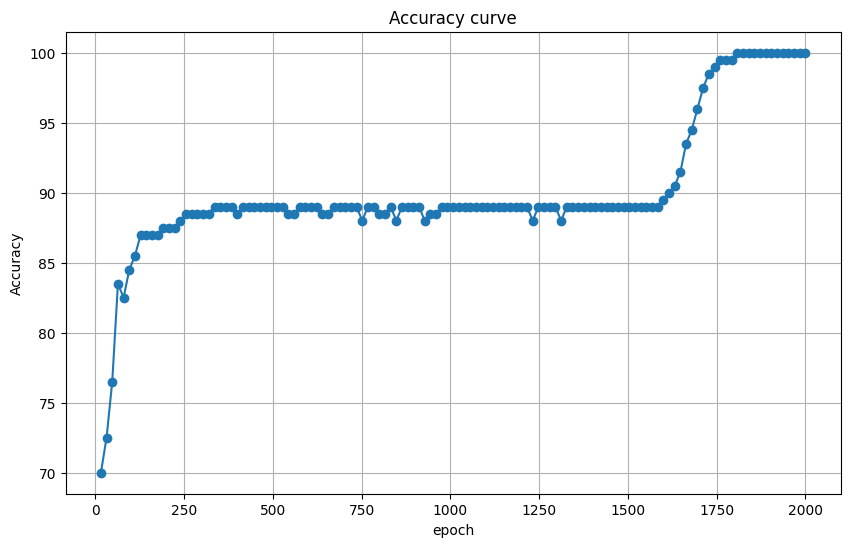

In [98]:
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

epoch 1000: loss : 0.2482395514 accuracy=65.50%
epoch 2000: loss : 0.2452430768 accuracy=70.50%
epoch 3000: loss : 0.2329747159 accuracy=73.50%
epoch 4000: loss : 0.1662207670 accuracy=79.00%
epoch 5000: loss : 0.1025242598 accuracy=85.50%
epoch 6000: loss : 0.0867496058 accuracy=87.50%
epoch 7000: loss : 0.0833559706 accuracy=88.00%
epoch 8000: loss : 0.0823742761 accuracy=88.00%
epoch 9000: loss : 0.0820104690 accuracy=88.00%
epoch 10000: loss : 0.0818423121 accuracy=88.00%
last accuracy=88.00%
loss=0.0818 accuracy=88.00%


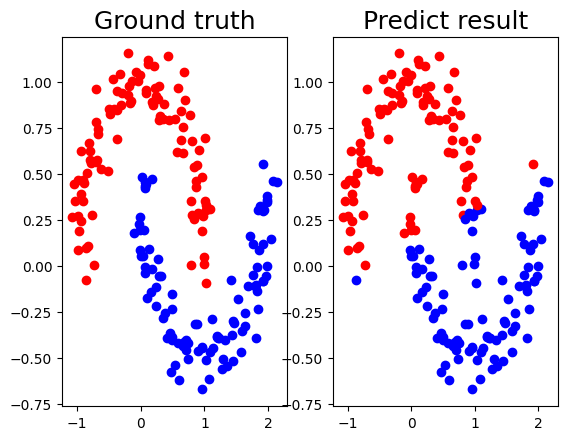

In [64]:
#x,y = generate_linear(n = 1000)
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
x,y= generate_XOR_hard_2()
x = moon_x
y = moon_y
m = model()
m.clear()
#m.set_optimizer(Momentum(0.9))
m.add_layer(2,4,sigmoid,derivative_sigmoid)
m.add_layer(4,5,sigmoid,derivative_sigmoid)
m.add_layer(5,1,sigmoid,derivative_sigmoid)
m.training(10000,x,y,0.001,1000,batch=16)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))

epoch 1000: loss : 0.0640683835 accuracy=90.57%
epoch 2000: loss : 0.0639441243 accuracy=90.56%
epoch 3000: loss : 0.0647614792 accuracy=90.09%
epoch 4000: loss : 0.0639676107 accuracy=90.51%
epoch 5000: loss : 0.0643115412 accuracy=90.23%
epoch 6000: loss : 0.0645027145 accuracy=90.35%
epoch 7000: loss : 0.0637678947 accuracy=90.53%
epoch 8000: loss : 0.0633462441 accuracy=90.59%
epoch 9000: loss : 0.0632723850 accuracy=90.58%
epoch 10000: loss : 0.0635096402 accuracy=90.64%
last accuracy=90.64%
loss=0.0635 accuracy=90.64%


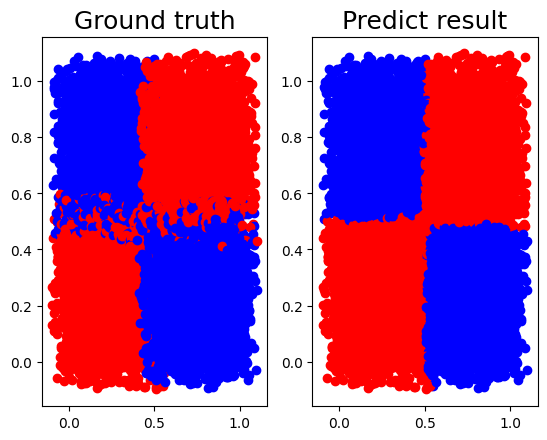

In [27]:
#x,y = generate_linear(n = 1000)
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
x,y= generate_XOR_hard_2()
m = model()
m.clear()
m.set_optimizer(Momentum(0.9))
m.add_layer(2,7,relu,derivative_relu)
m.add_layer(7,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(10000,x,y,0.001,1000,batch=32)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))


epoch 1000: loss : 0.0044193944 accuracy=99.36%
last accuracy=99.36%
loss=0.0044 accuracy=99.36%


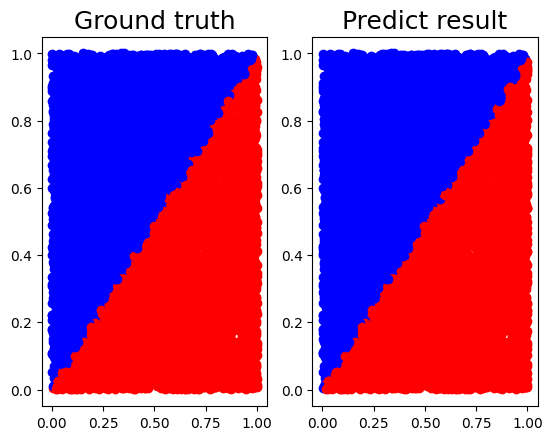

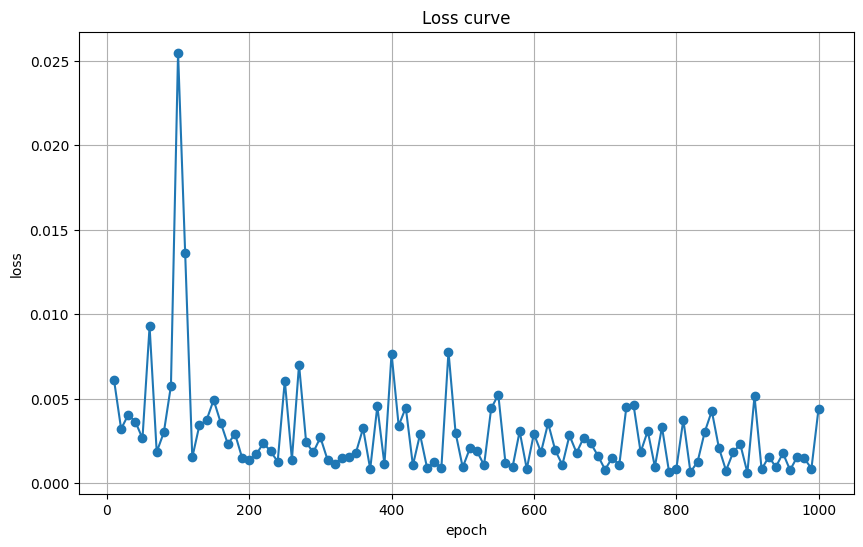

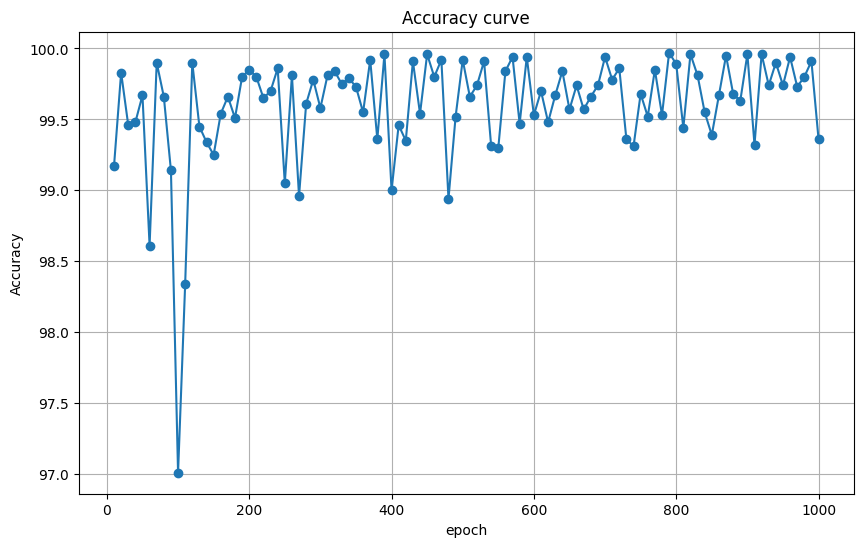

In [100]:
x,y = generate_linear(n = 10000)
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
m = model(10)
m.clear()
m.add_layer(2,7,relu,derivative_relu)
m.add_layer(7,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(1000,x,y,0.1,1000,batch=16)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

epoch 5000: loss : 0.0000394579 accuracy=100.00%
last accuracy=100.00%
Iter   0 |    Ground truth: 1.000000 |   prediction: 0.999343 |
Iter   1 |    Ground truth: 1.000000 |   prediction: 0.999241 |
Iter   2 |    Ground truth: 0.000000 |   prediction: 0.006348 |
Iter   3 |    Ground truth: 1.000000 |   prediction: 0.999002 |
Iter   4 |    Ground truth: 1.000000 |   prediction: 0.999191 |
Iter   5 |    Ground truth: 1.000000 |   prediction: 0.999330 |
Iter   6 |    Ground truth: 1.000000 |   prediction: 0.999371 |
Iter   7 |    Ground truth: 1.000000 |   prediction: 0.999368 |
Iter   8 |    Ground truth: 1.000000 |   prediction: 0.999204 |
Iter   9 |    Ground truth: 1.000000 |   prediction: 0.994414 |
Iter  10 |    Ground truth: 1.000000 |   prediction: 0.999333 |
Iter  11 |    Ground truth: 1.000000 |   prediction: 0.999352 |
Iter  12 |    Ground truth: 1.000000 |   prediction: 0.977920 |
Iter  13 |    Ground truth: 0.000000 |   prediction: 0.029097 |
Iter  14 |    Ground truth: 1.000

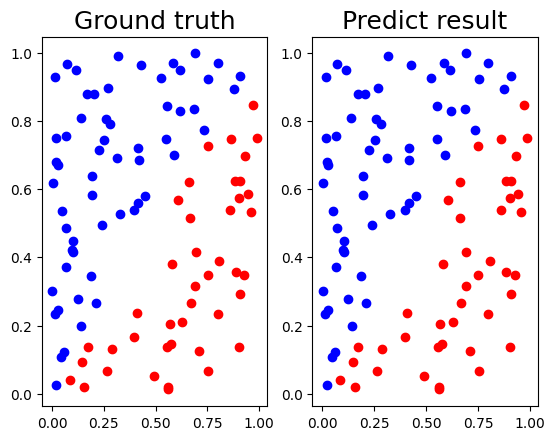

In [19]:
x,y = generate_linear(n = 100)
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
m = model()
m.clear()
m.add_layer(2,7,relu,derivative_relu)
m.add_layer(7,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(100000,x,y,0.1,5000,batch=256)

pred_y = m.testing(x,y)
show_result(x,y,(pred_y > 0.5))


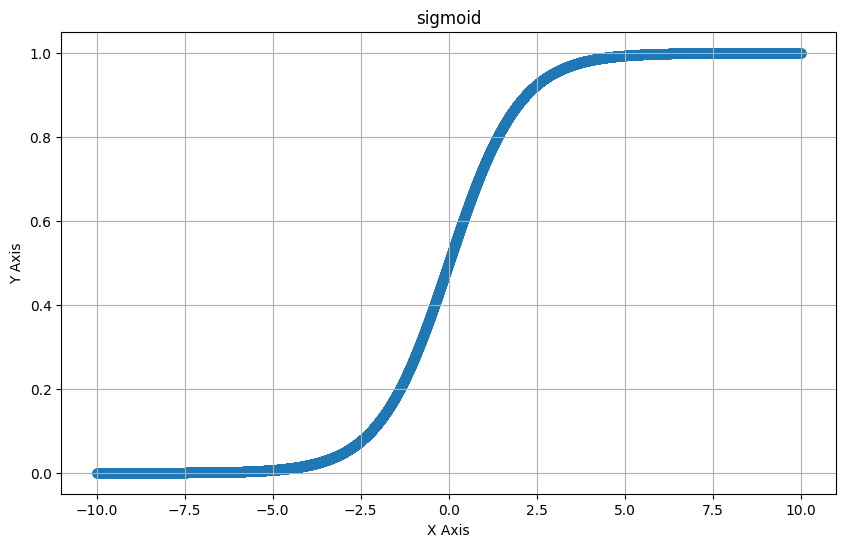

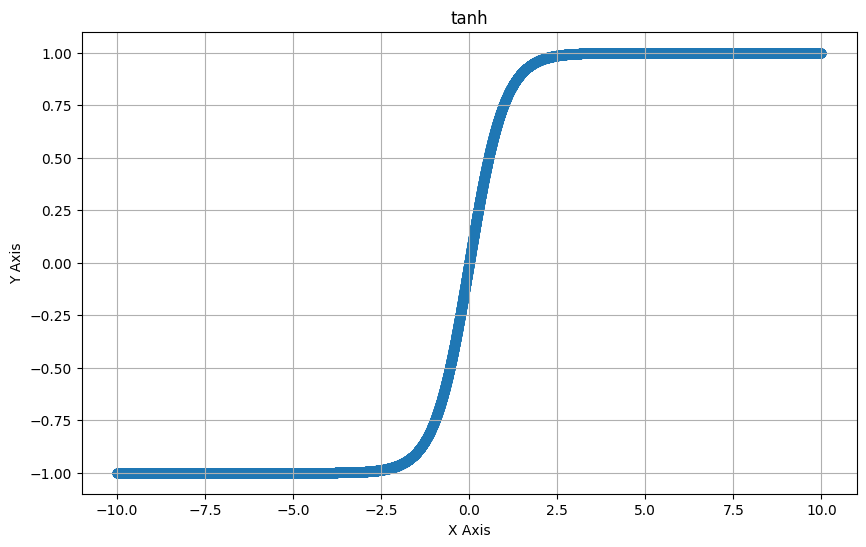

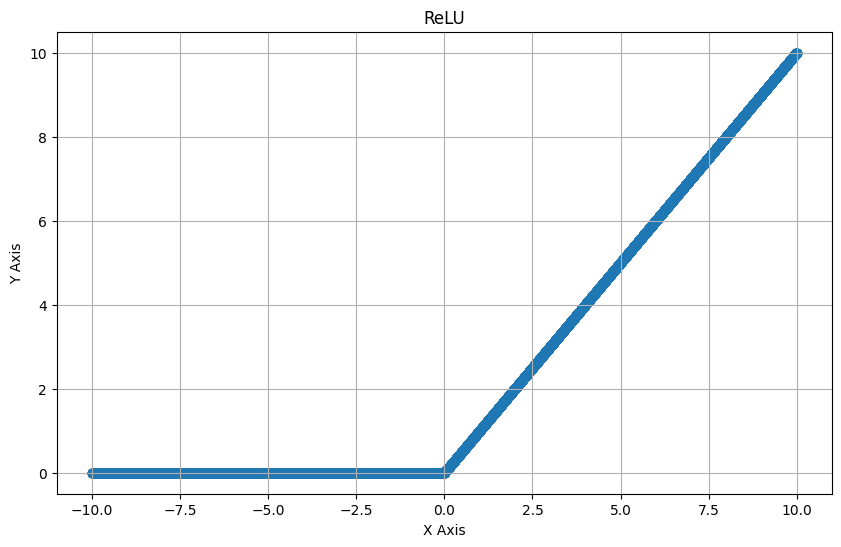

In [76]:
x = []
sigmoid_y = []
tanh_y = []
relu_y = []
for i in range(-10000,10000):
    v = float(i)/1000
    x.append(v)
    sigmoid_y.append(sigmoid(v))
    tanh_y.append(tanh(v))
    relu_y.append(relu(v))

draw_scatter_plot(x, sigmoid_y, 'sigmoid')
draw_scatter_plot(x, tanh_y, 'tanh')
draw_scatter_plot(x, relu_y, 'ReLU')

---START TRAINING---
epoch      100: loss : 0.2498853331
epoch      200: loss : 0.2498003714
epoch      300: loss : 0.2496937947
epoch      400: loss : 0.2495432784
epoch      500: loss : 0.2493050988
epoch      600: loss : 0.2488727215
epoch      700: loss : 0.2479128666
epoch      800: loss : 0.2449369282
epoch      900: loss : 0.2289297439
epoch     1000: loss : 0.1361682368
spent: 30.90523648262024s
---FINISH TRAINING---
loss=0.1362 accuracy=99.80%


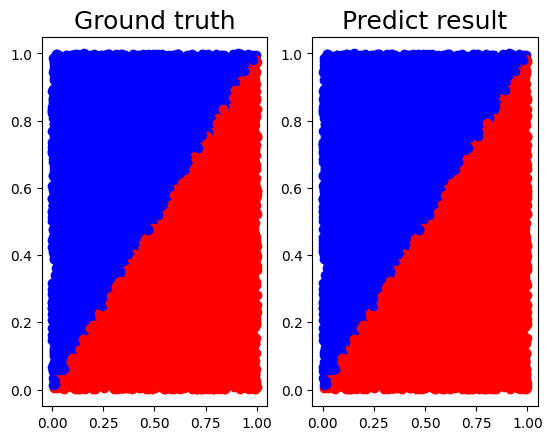

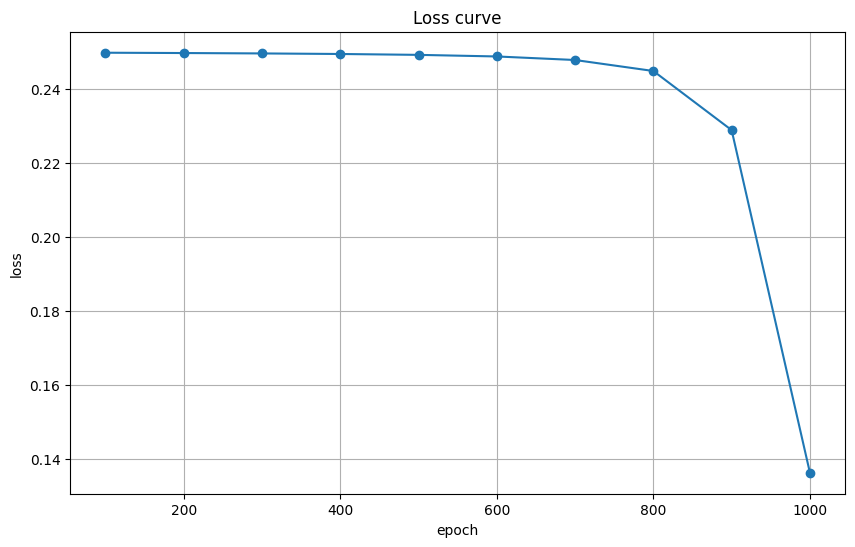

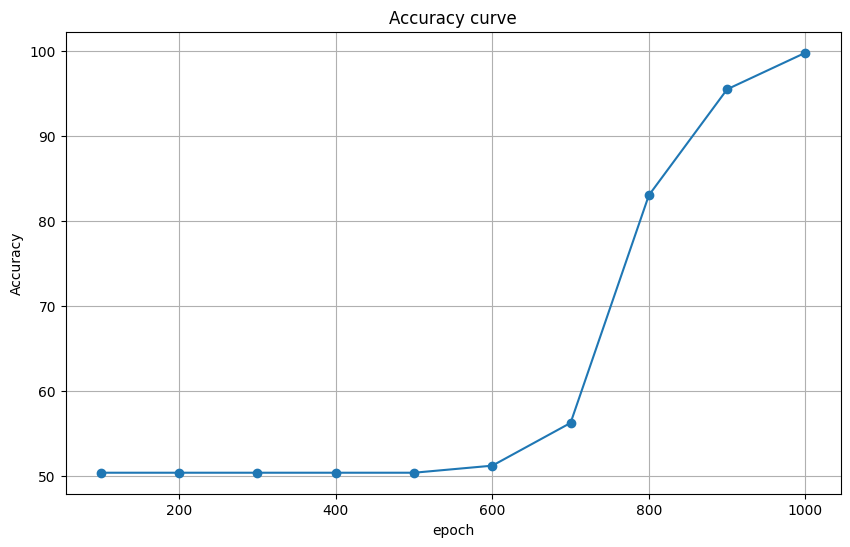

In [194]:
x,y = generate_linear(n = 10000)
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
m = model(100)
#m.set_optimizer(Momentum(0.9))
m.clear()
m.add_layer(2,4,sigmoid,derivative_sigmoid)
m.add_layer(4,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(1000,x,y,0.0001,100,batch=32)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch      100: loss : 0.2435768228
epoch      200: loss : 0.0173853200
epoch      300: loss : 0.0106079517
epoch      400: loss : 0.0081680268
epoch      500: loss : 0.0067708078
epoch      600: loss : 0.0058787222
epoch      700: loss : 0.0052704563
epoch      800: loss : 0.0047593374
epoch      900: loss : 0.0043890697
epoch     1000: loss : 0.0040914816
spent: 35.76037526130676s
---FINISH TRAINING---
loss=0.0041 accuracy=99.88%


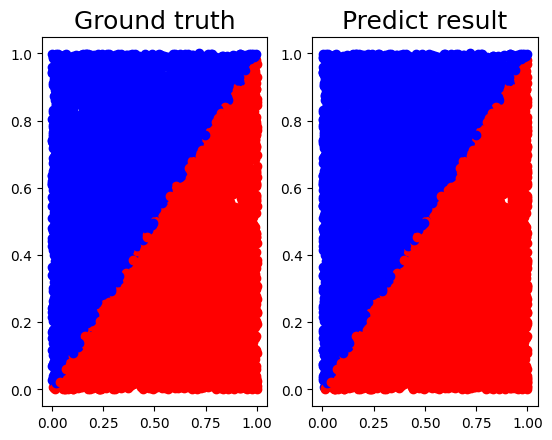

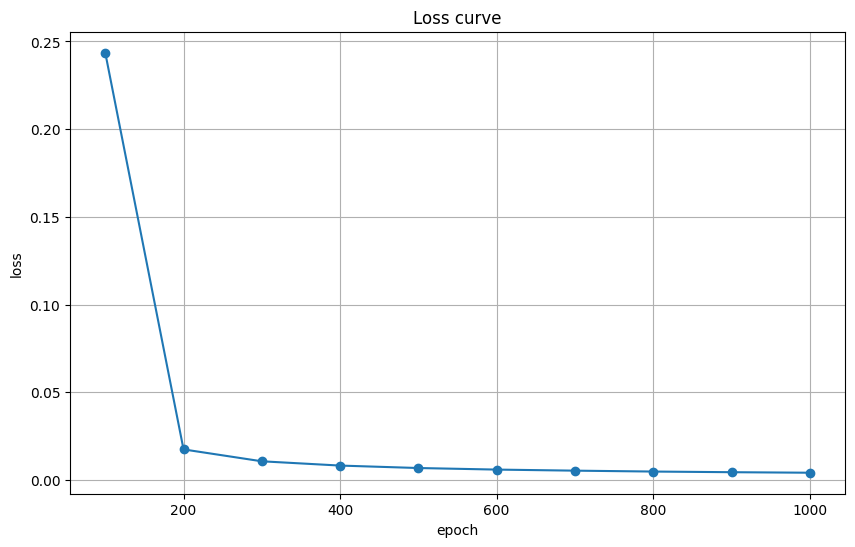

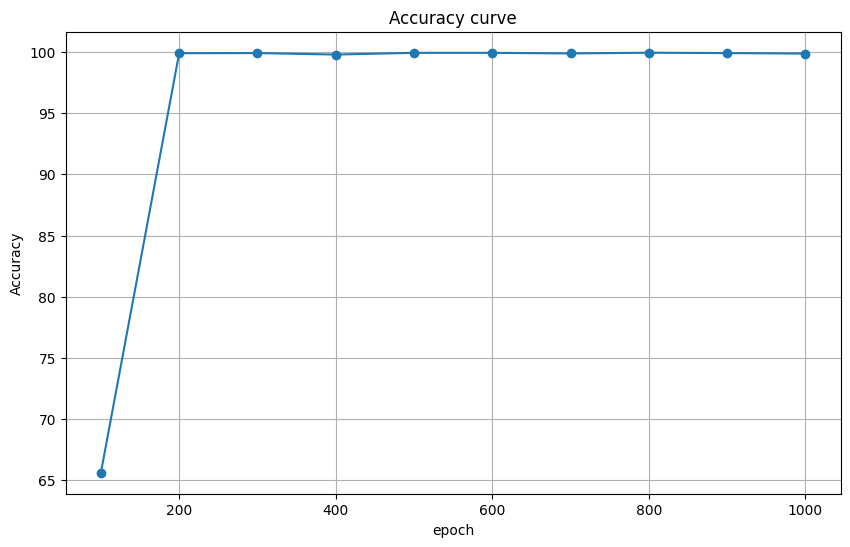

In [195]:
x,y = generate_linear(n = 10000)
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
m = model(100)
m.set_optimizer(Momentum(0.9))
m.clear()
m.add_layer(2,4,sigmoid,derivative_sigmoid)
m.add_layer(4,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(1000,x,y,0.0001,100,batch=32)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch      100: loss : 0.0052056205
epoch      200: loss : 0.0038520729
epoch      300: loss : 0.0026780970
epoch      400: loss : 0.0043465837
epoch      500: loss : 0.0019952600
epoch      600: loss : 0.0016877267
epoch      700: loss : 0.0014776867
epoch      800: loss : 0.0012551061
epoch      900: loss : 0.0011142598
epoch     1000: loss : 0.0010774817
spent: 36.02401947975159s
---FINISH TRAINING---
loss=0.0011 accuracy=99.96%


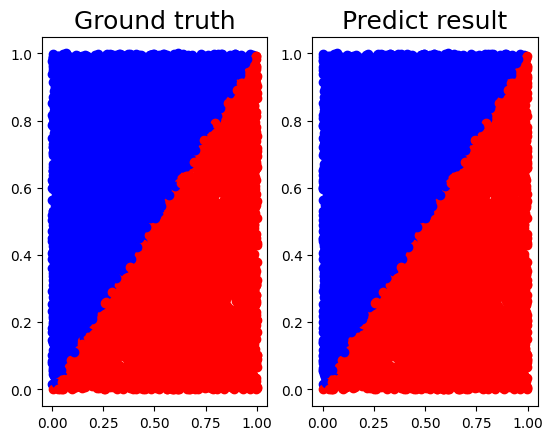

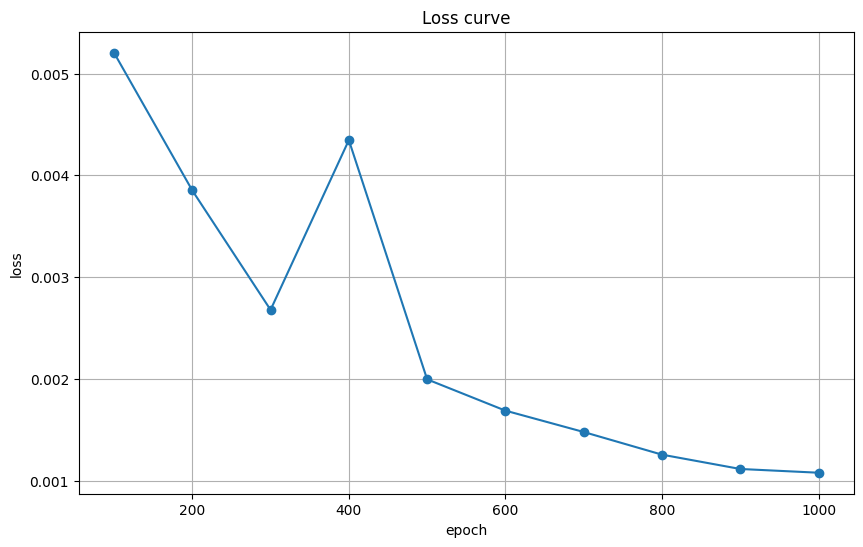

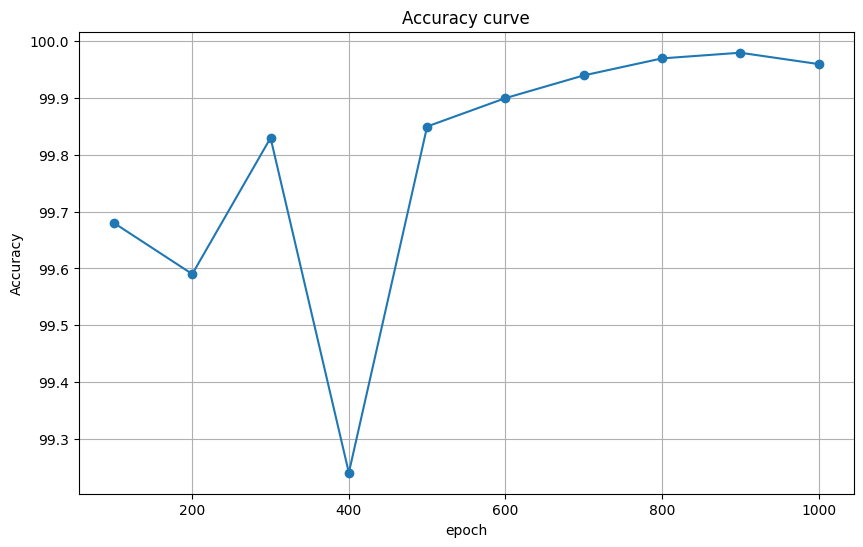

In [202]:
x,y = generate_linear(n = 10000)
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
m = model(100)
m.set_optimizer(Momentum(0.9))
m.clear()
m.add_layer(2,4,relu,derivative_relu)
m.add_layer(4,4,relu,derivative_relu)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(1000,x,y,0.0001,100,batch=32)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch      100: loss : 0.2498977955
epoch      200: loss : 0.2498251876
epoch      300: loss : 0.2497611847
epoch      400: loss : 0.2497329881
epoch      500: loss : 0.2495264324
epoch      600: loss : 0.2493112635
epoch      700: loss : 0.2489644927
epoch      800: loss : 0.2483789609
epoch      900: loss : 0.2471224901
epoch     1000: loss : 0.2446382968
spent: 0.731208324432373s
---FINISH TRAINING---
loss=0.2446 accuracy=50.00%


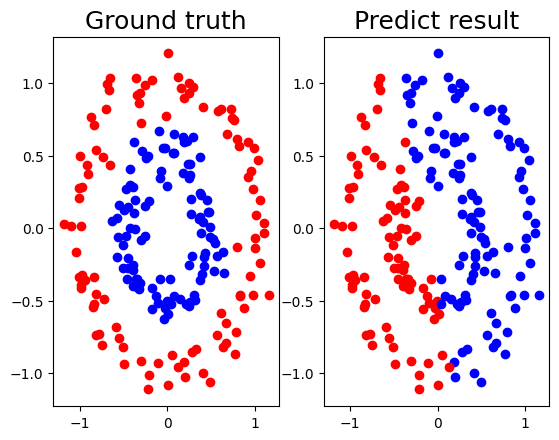

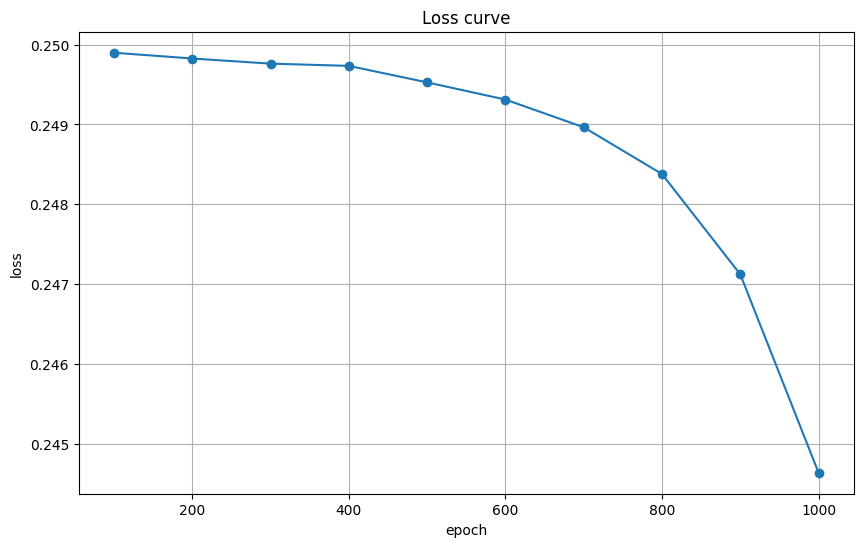

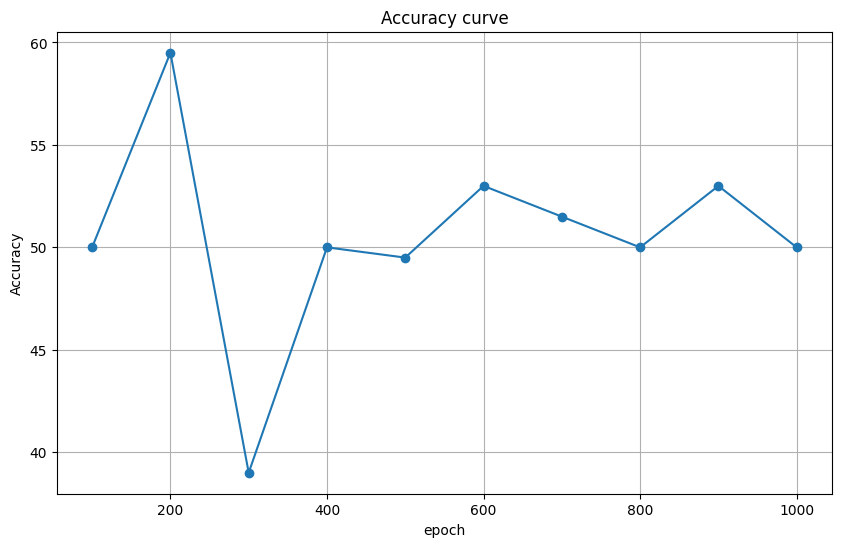

In [206]:
#x,y = generate_linear(n = 10000)
x = circle_x
y = circle_y
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
m = model(100)
m.set_optimizer(Momentum(0.9))
m.clear()
m.add_layer(2,4,sigmoid,derivative_sigmoid)
m.add_layer(4,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(1000,x,y,0.001,100,batch=32)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch      100: loss : 0.2440455485
epoch      200: loss : 0.2399360203
epoch      300: loss : 0.2327509124
epoch      400: loss : 0.2201754903
epoch      500: loss : 0.1965452695
epoch      600: loss : 0.1632025345
epoch      700: loss : 0.0917733477
epoch      800: loss : 0.0444674842
epoch      900: loss : 0.0291325038
epoch     1000: loss : 0.0221893771
spent: 0.7812454700469971s
---FINISH TRAINING---
loss=0.0222 accuracy=99.00%


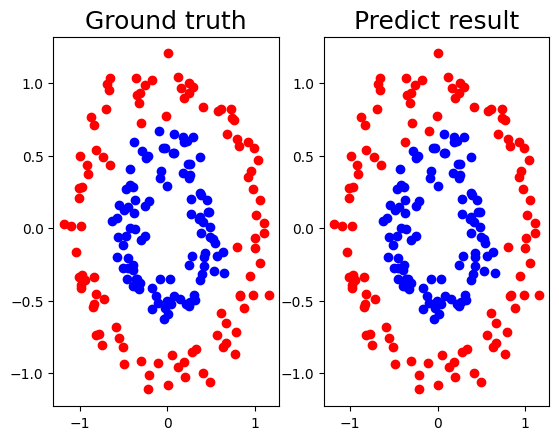

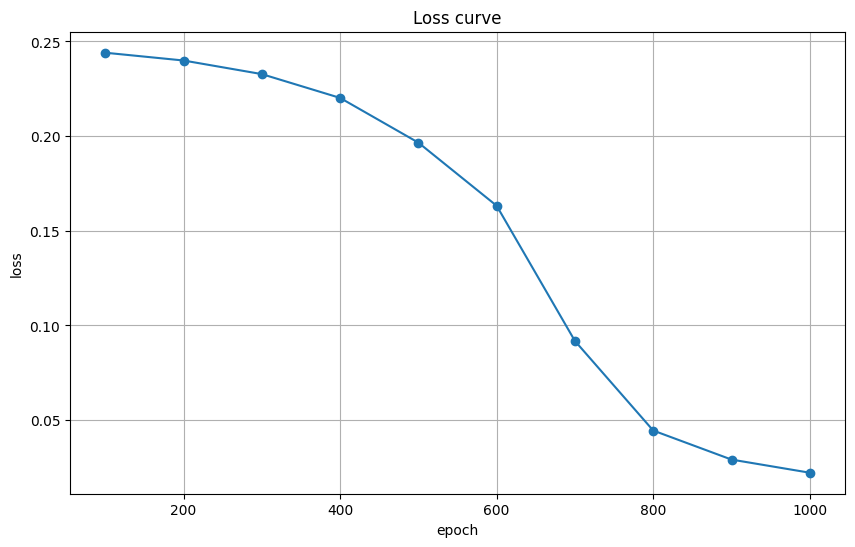

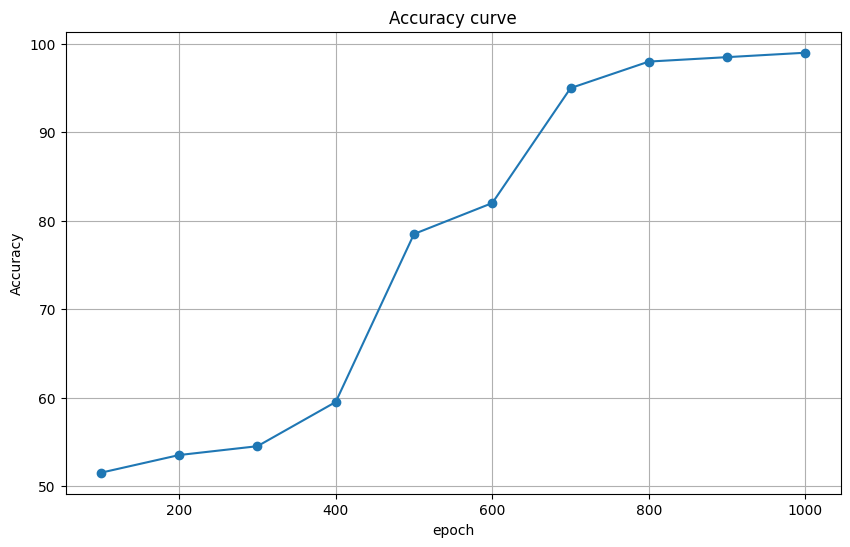

In [207]:
#x,y = generate_linear(n = 10000)
x = circle_x
y = circle_y
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
m = model(100)
#m.set_optimizer(Momentum(0.9))
m.clear()
m.add_layer(2,4,relu,derivative_relu)
m.add_layer(4,4,relu,derivative_relu)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(1000,x,y,0.001,100,batch=32)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch     1000: loss : 0.0794363450
epoch     2000: loss : 0.0755491493
epoch     3000: loss : 0.0758901183
epoch     4000: loss : 0.0754469290
epoch     5000: loss : 0.0755825717
epoch     6000: loss : 0.0759780206
epoch     7000: loss : 0.0753684921
epoch     8000: loss : 0.0759554346
epoch     9000: loss : 0.0753325358
epoch    10000: loss : 0.0756983695
spent: 7.418144941329956s
---FINISH TRAINING---
loss=0.0757 accuracy=88.50%


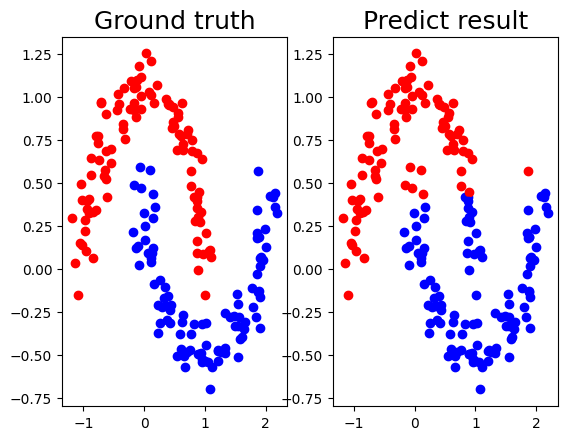

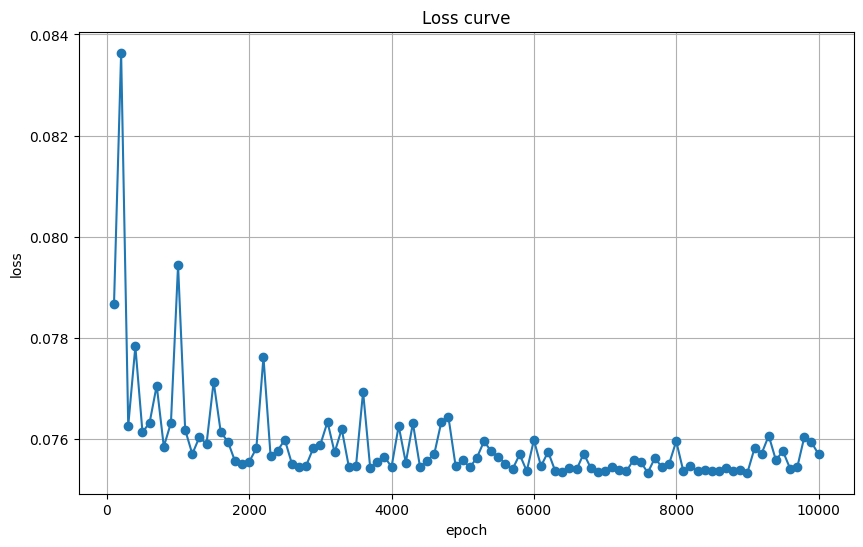

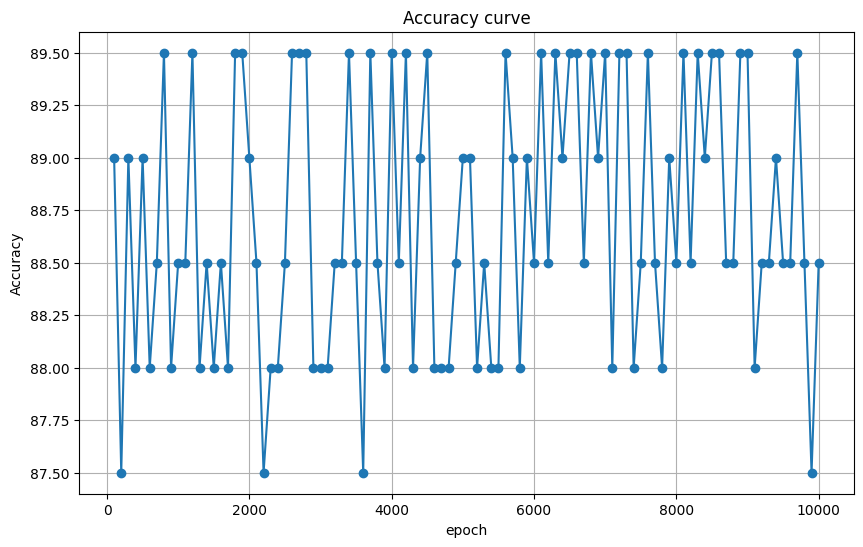

In [219]:
#x,y = generate_linear(n = 10000)
x = moon_x
y = moon_y
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
m = model(100)
m.set_optimizer(Momentum(0.9))
m.clear()
m.add_layer(2,4,relu,derivative_relu)
m.add_layer(4,4,relu,derivative_relu)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(10000,x,y,0.001,1000,batch=32)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch      100: loss : 0.0271374333
epoch      200: loss : 0.0041229612
epoch      300: loss : 0.0023271206
epoch      400: loss : 0.0028322380
epoch      500: loss : 0.0010056631
epoch      600: loss : 0.0007916691
epoch      700: loss : 0.0005360368
epoch      800: loss : 0.0004332236
epoch      900: loss : 0.0003392075
epoch     1000: loss : 0.0002767314
epoch     1100: loss : 0.0002402733
epoch     1200: loss : 0.0002132152
epoch     1300: loss : 0.0001854884
epoch     1400: loss : 0.0001686402
epoch     1500: loss : 0.0001527795
epoch     1600: loss : 0.0001399211
epoch     1700: loss : 0.0001280547
epoch     1800: loss : 0.0001179049
epoch     1900: loss : 0.0001091383
epoch     2000: loss : 0.0001026237
spent: 1.3860325813293457s
---FINISH TRAINING---
loss=0.0001 accuracy=100.00%


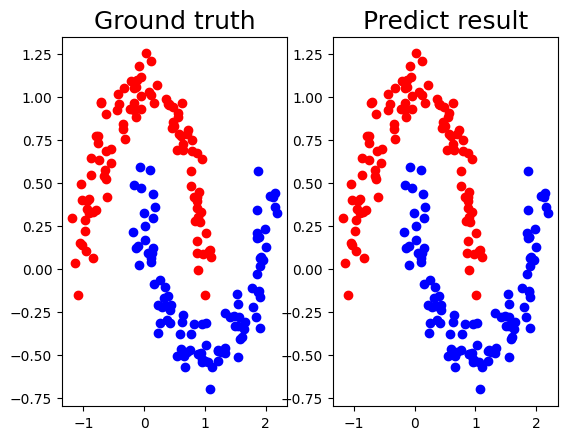

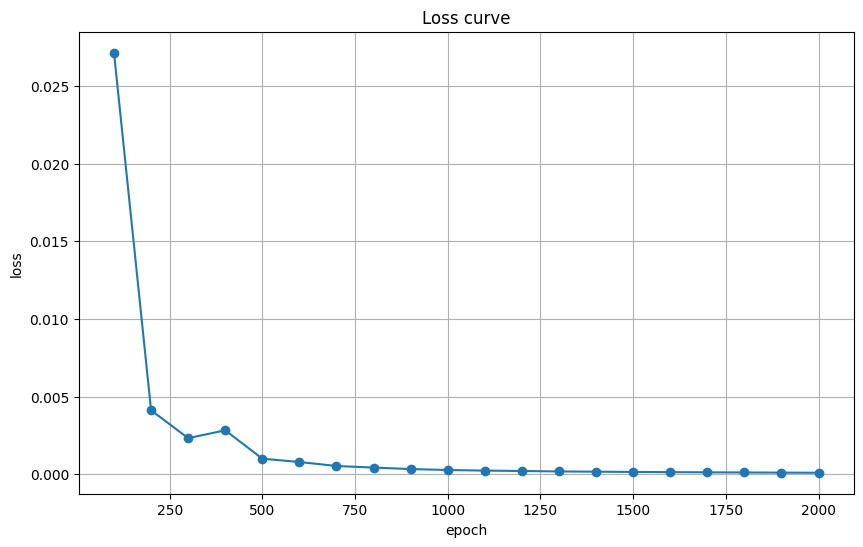

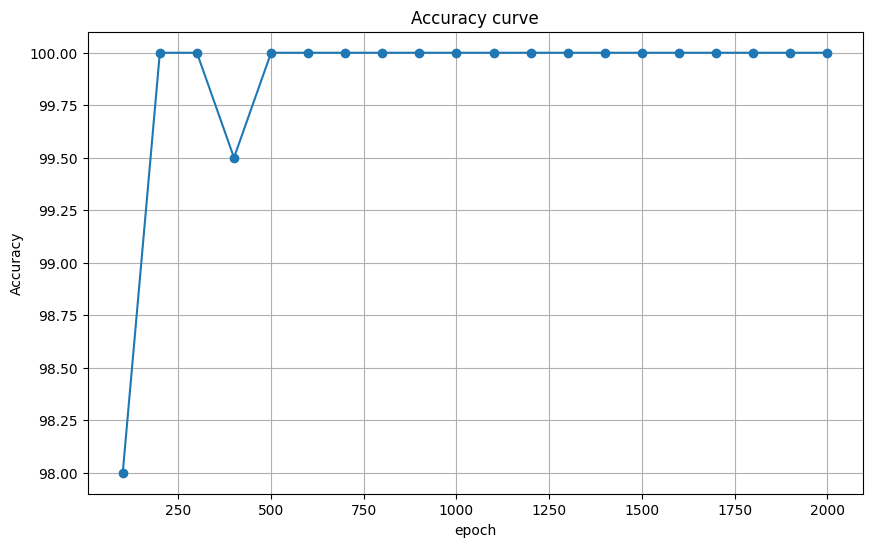

In [243]:
#x,y = generate_linear(n = 10000)
x = moon_x
y = moon_y
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
m = model(100)
#m.set_optimizer(Momentum(0.9))
m.clear()
m.add_layer(2,4,relu,derivative_relu)
m.add_layer(4,4,relu,derivative_relu)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(2000,x,y,0.01,100,batch=32)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch      100: loss : 0.2495000475
epoch      200: loss : 0.2492279042
epoch      300: loss : 0.2489131470
epoch      400: loss : 0.2485309872
epoch      500: loss : 0.2480489280
epoch      600: loss : 0.2474177403
epoch      700: loss : 0.2465630494
epoch      800: loss : 0.2453645654
epoch      900: loss : 0.2436231813
epoch     1000: loss : 0.2409981660
epoch     1100: loss : 0.2369046280
epoch     1200: loss : 0.2303805716
epoch     1300: loss : 0.2200649631
epoch     1400: loss : 0.2047508433
epoch     1500: loss : 0.1850056510
epoch     1600: loss : 0.1643171881
epoch     1700: loss : 0.1466178908
epoch     1800: loss : 0.1331778696
epoch     1900: loss : 0.1232445399
epoch     2000: loss : 0.1157777657
spent: 1.3276479244232178s
---FINISH TRAINING---
loss=0.1158 accuracy=83.00%


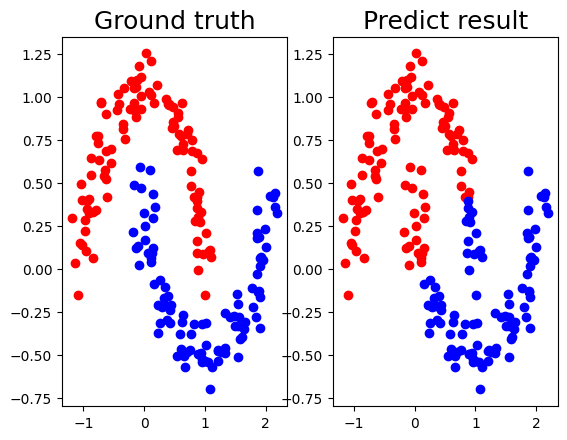

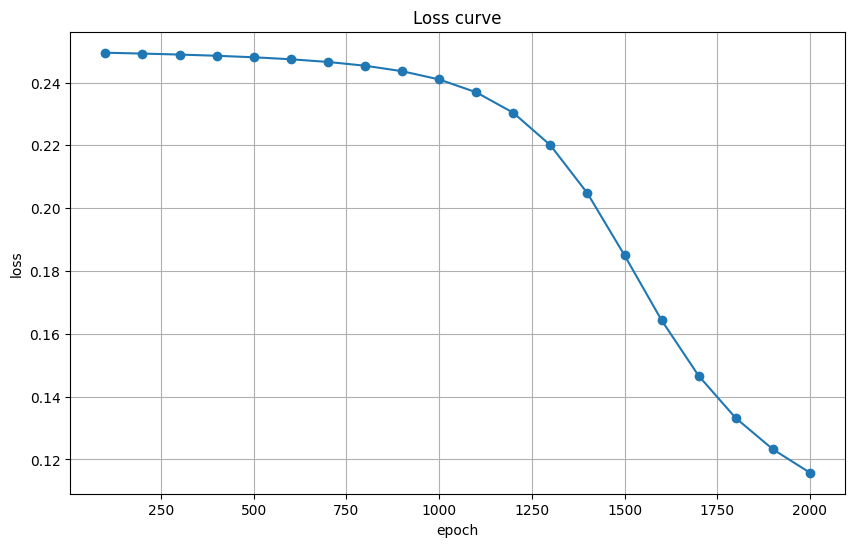

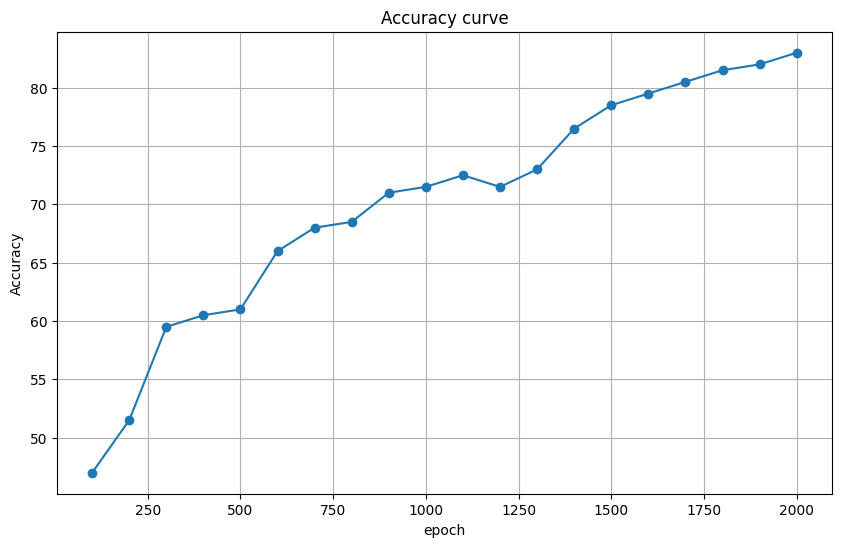

In [244]:
#x,y = generate_linear(n = 10000)
x = moon_x
y = moon_y
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
m = model(100)
#m.set_optimizer(Momentum(0.9))
m.clear()
m.add_layer(2,4,sigmoid,derivative_sigmoid)
m.add_layer(4,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(2000,x,y,0.001,100,batch=32)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch      100: loss : 0.0920391924
epoch      200: loss : 0.0912692255
epoch      300: loss : 0.0886690748
epoch      400: loss : 0.0878672819
epoch      500: loss : 0.0872195009
epoch      600: loss : 0.0867142366
epoch      700: loss : 0.0863411966
epoch      800: loss : 0.0858806641
epoch      900: loss : 0.0860787696
epoch     1000: loss : 0.0852373466
epoch     1100: loss : 0.0853102529
epoch     1200: loss : 0.0846937973
epoch     1300: loss : 0.0842115339
epoch     1400: loss : 0.0097285201
epoch     1500: loss : 0.0012651288
epoch     1600: loss : 0.0005724630
epoch     1700: loss : 0.0003611002
epoch     1800: loss : 0.0002611817
epoch     1900: loss : 0.0002034641
epoch     2000: loss : 0.0001661905
spent: 1.3023171424865723s
---FINISH TRAINING---
loss=0.0002 accuracy=100.00%


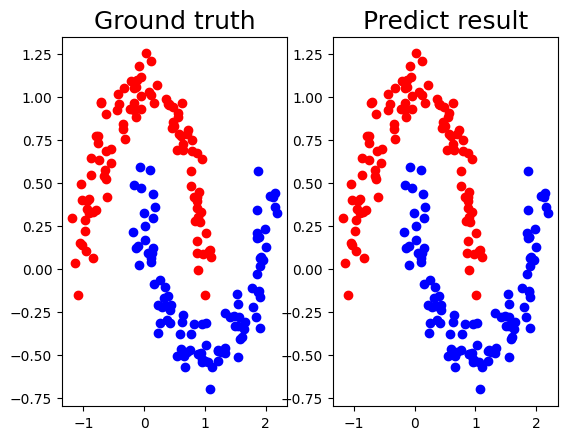

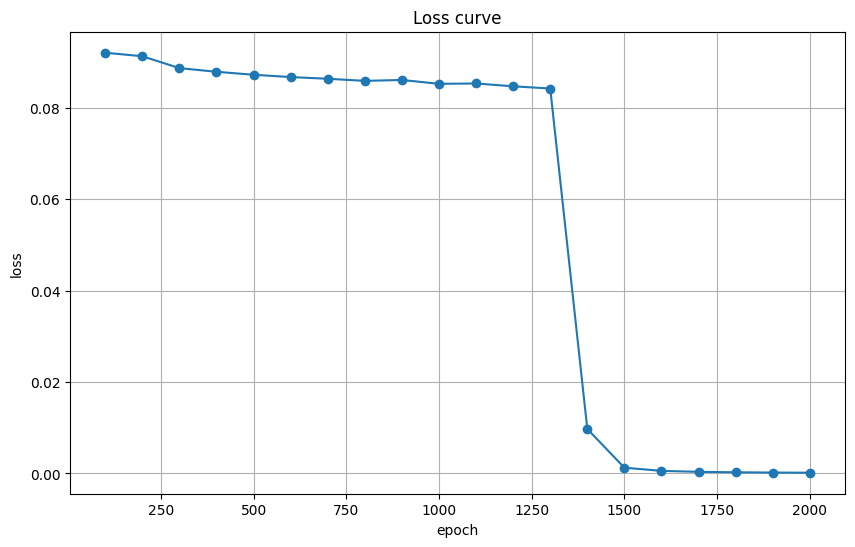

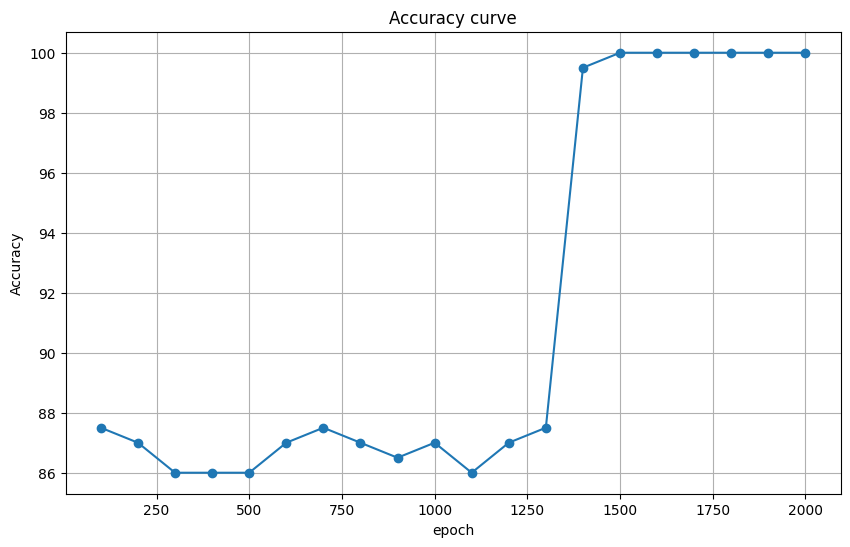

In [268]:
#x,y = generate_linear(n = 10000)
x = moon_x
y = moon_y
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
m = model(100)
#m.set_optimizer(Momentum(0.9))
m.clear()
m.add_layer(2,4,sigmoid,derivative_sigmoid)
m.add_layer(4,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(2000,x,y,0.1,100,batch=32)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch      100: loss : 0.0165038715
epoch      200: loss : 0.0023672171
epoch      300: loss : 0.0063305697
epoch      400: loss : 0.0053082428
epoch      500: loss : 0.0006097254
epoch      600: loss : 0.0002730639
epoch      700: loss : 0.0002323780
epoch      800: loss : 0.0215271515
epoch      900: loss : 0.0186774625
epoch     1000: loss : 0.0025144624
epoch     1100: loss : 0.0078891194
epoch     1200: loss : 0.0007132203
epoch     1300: loss : 0.0204334465
epoch     1400: loss : 0.0000946403
epoch     1500: loss : 0.0000813938
epoch     1600: loss : 0.0195263886
epoch     1700: loss : 0.0001350658
epoch     1800: loss : 0.0070482221
epoch     1900: loss : 0.0093425724
epoch     2000: loss : 0.0122406437
spent: 66.47796940803528s
---FINISH TRAINING---
loss=0.0122 accuracy=98.73%


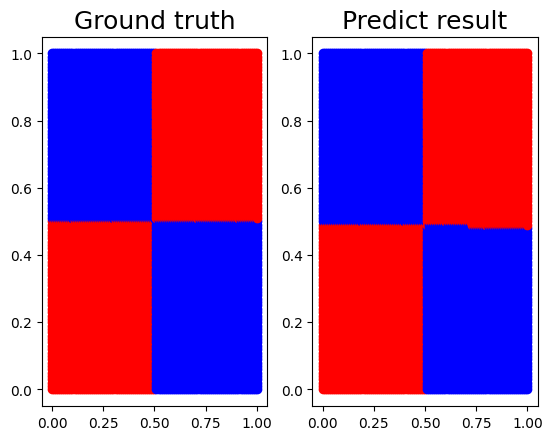

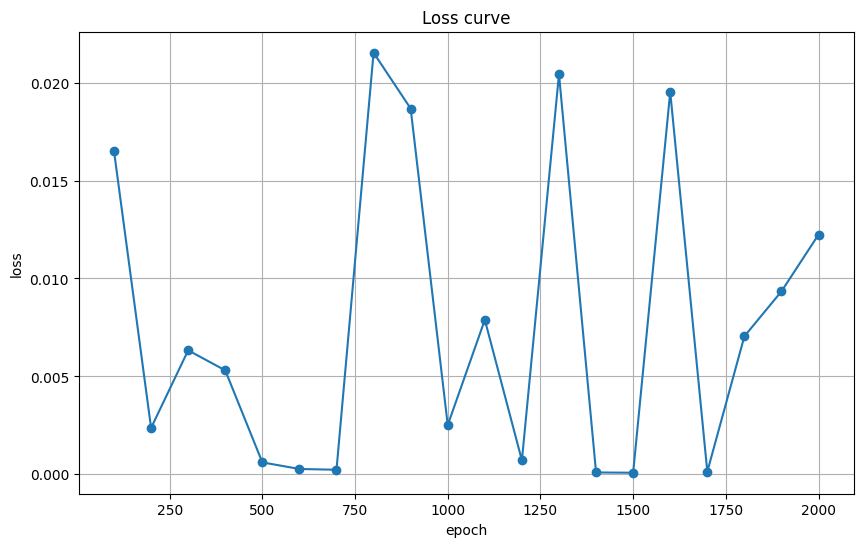

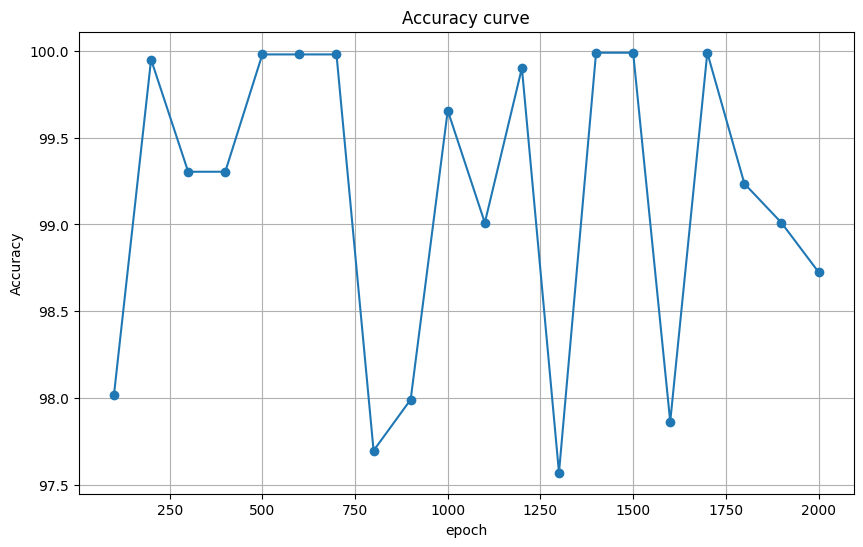

In [221]:
#x,y = generate_linear(n = 10000)
x = xor_hard_x
y = xor_hard_y
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
m = model(100)
#m.set_optimizer(Momentum(0.9))
m.clear()
m.add_layer(2,4,relu,derivative_relu)
m.add_layer(4,4,relu,derivative_relu)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(2000,x,y,0.01,100,batch=32)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch      100: loss : 0.0287416821
epoch      200: loss : 0.0099525967
epoch      300: loss : 0.0077941574
epoch      400: loss : 0.0153516585
epoch      500: loss : 0.0054871759
epoch      600: loss : 0.0061459944
epoch      700: loss : 0.0032526873
epoch      800: loss : 0.0076043243
epoch      900: loss : 0.0031686371
epoch     1000: loss : 0.0027288682
epoch     1100: loss : 0.0034240399
epoch     1200: loss : 0.0028072697
epoch     1300: loss : 0.0019539846
epoch     1400: loss : 0.0018530344
epoch     1500: loss : 0.0016738577
epoch     1600: loss : 0.0016925907
epoch     1700: loss : 0.0020718128
epoch     1800: loss : 0.0015220673
epoch     1900: loss : 0.0015485871
epoch     2000: loss : 0.0015199282
spent: 64.75971722602844s
---FINISH TRAINING---
loss=0.0015 accuracy=99.90%


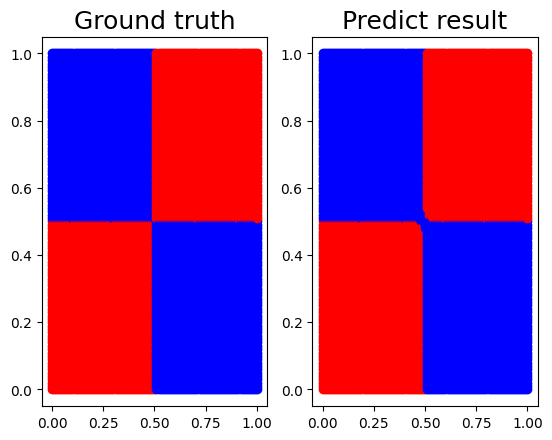

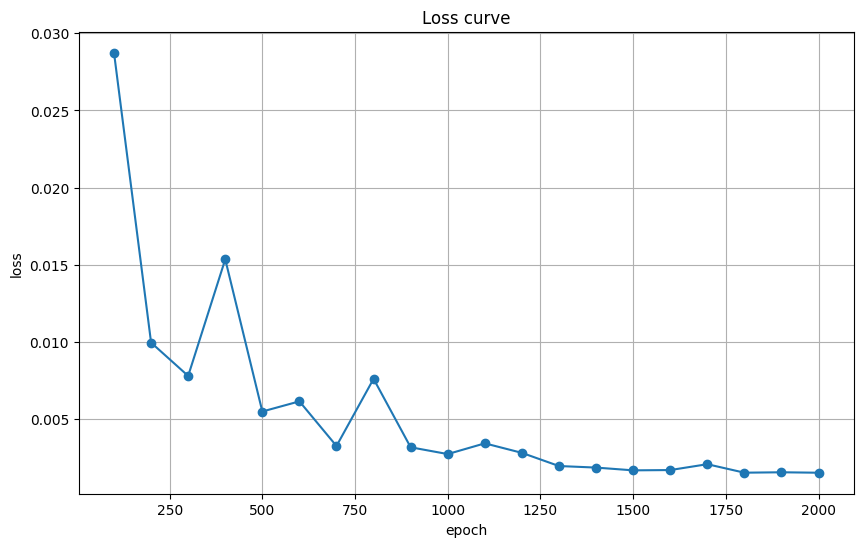

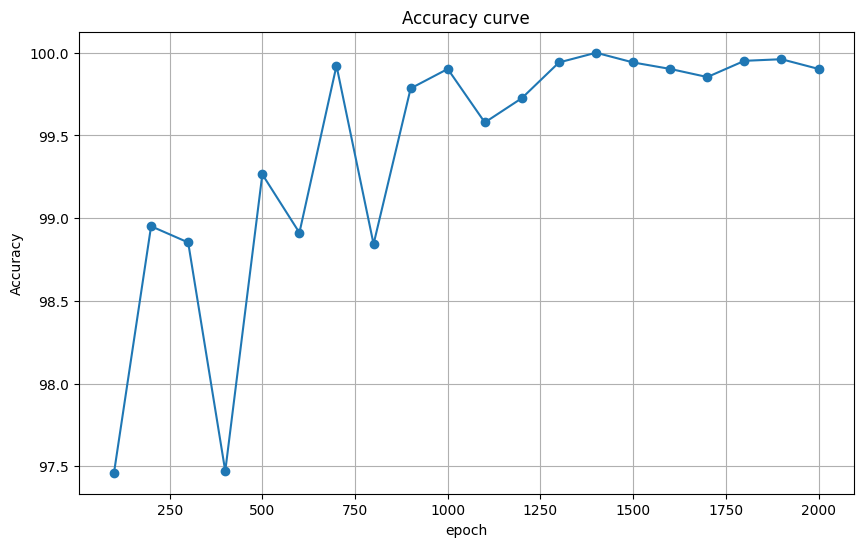

In [222]:
#x,y = generate_linear(n = 10000)
x = xor_hard_x
y = xor_hard_y
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
m = model(100)
#m.set_optimizer(Momentum(0.9))
m.clear()
m.add_layer(2,4,sigmoid,derivative_sigmoid)
m.add_layer(4,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(2000,x,y,0.01,100,batch=32)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch      100: loss : 0.1301020689
epoch      200: loss : 0.0670343594
epoch      300: loss : 0.0636968503
epoch      400: loss : 0.0629052538
epoch      500: loss : 0.0624233089
epoch      600: loss : 0.0637210663
epoch      700: loss : 0.0653831682
epoch      800: loss : 0.0633119257
epoch      900: loss : 0.0634533628
epoch     1000: loss : 0.0628892998
epoch     1100: loss : 0.0643690147
epoch     1200: loss : 0.0627819950
epoch     1300: loss : 0.0629644784
epoch     1400: loss : 0.0628001270
epoch     1500: loss : 0.0629924668
epoch     1600: loss : 0.0626440852
epoch     1700: loss : 0.0624868483
epoch     1800: loss : 0.0630065514
epoch     1900: loss : 0.0625254817
epoch     2000: loss : 0.0643548811
spent: 72.7726902961731s
---FINISH TRAINING---
loss=0.0644 accuracy=90.39%


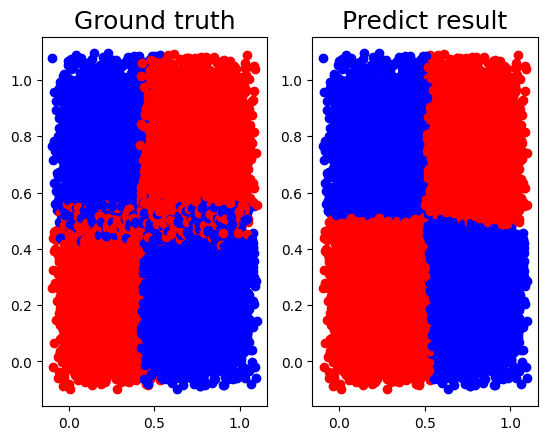

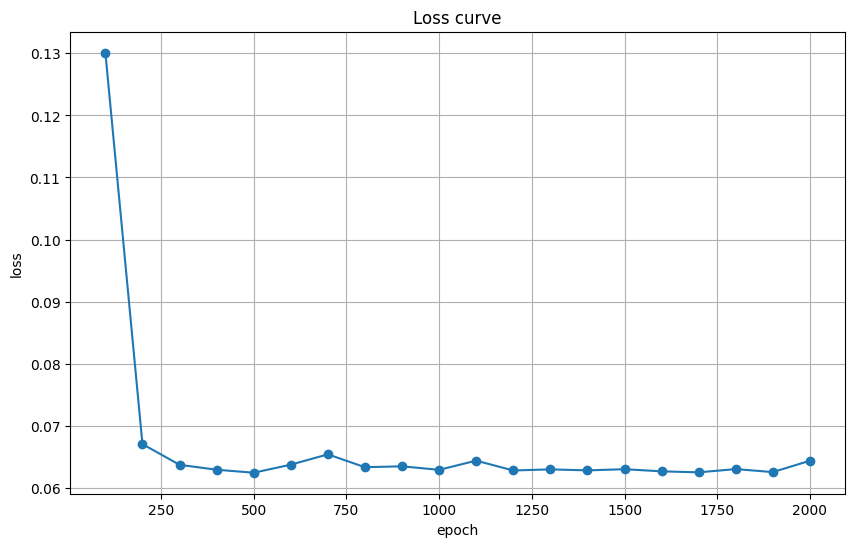

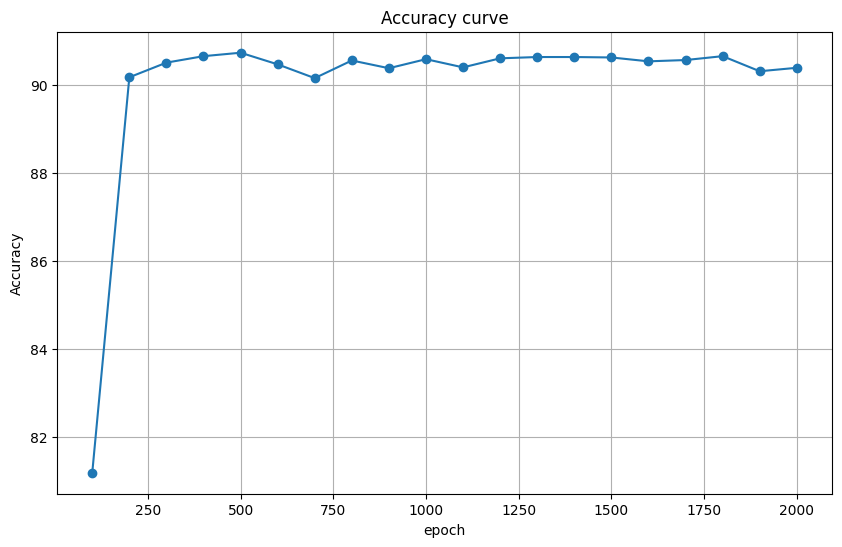

In [226]:
#x,y = generate_linear(n = 10000)
x = xor_hard_2_x
y = xor_hard_2_y
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
m = model(100)
m.set_optimizer(Momentum(0.9))
m.clear()
m.add_layer(2,4,relu,derivative_relu)
m.add_layer(4,4,relu,derivative_relu)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(2000,x,y,0.001,100,batch=32)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

---START TRAINING---
epoch      100: loss : 0.0710009712
epoch      200: loss : 0.0672963216
epoch      300: loss : 0.0642635233
epoch      400: loss : 0.0642603116
epoch      500: loss : 0.0638431680
epoch      600: loss : 0.0632746467
epoch      700: loss : 0.0652482769
epoch      800: loss : 0.0632033806
epoch      900: loss : 0.0633493623
epoch     1000: loss : 0.0641362119
epoch     1100: loss : 0.0635956917
epoch     1200: loss : 0.0644910811
epoch     1300: loss : 0.0631159548
epoch     1400: loss : 0.0631140738
epoch     1500: loss : 0.0631711395
epoch     1600: loss : 0.0637140844
epoch     1700: loss : 0.0634630776
epoch     1800: loss : 0.0637612659
epoch     1900: loss : 0.0631954616
epoch     2000: loss : 0.0630587606
spent: 70.95461535453796s
---FINISH TRAINING---
loss=0.0631 accuracy=90.48%


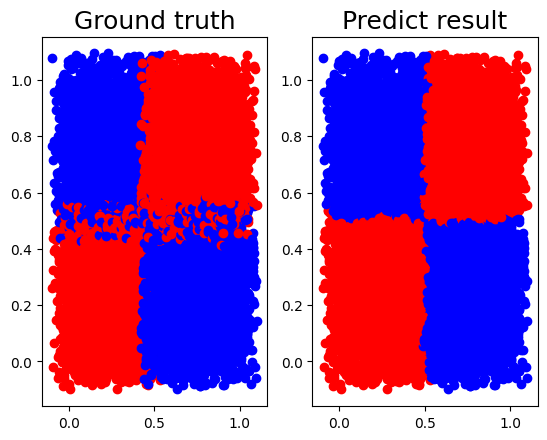

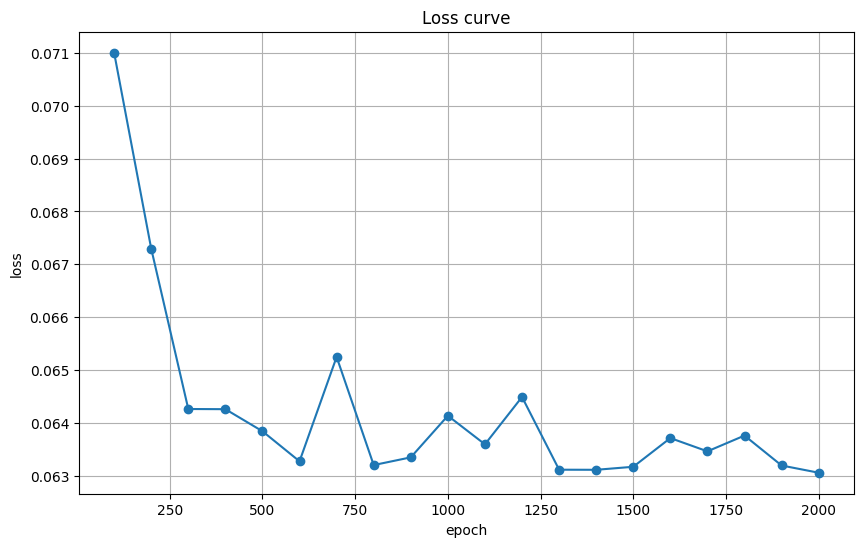

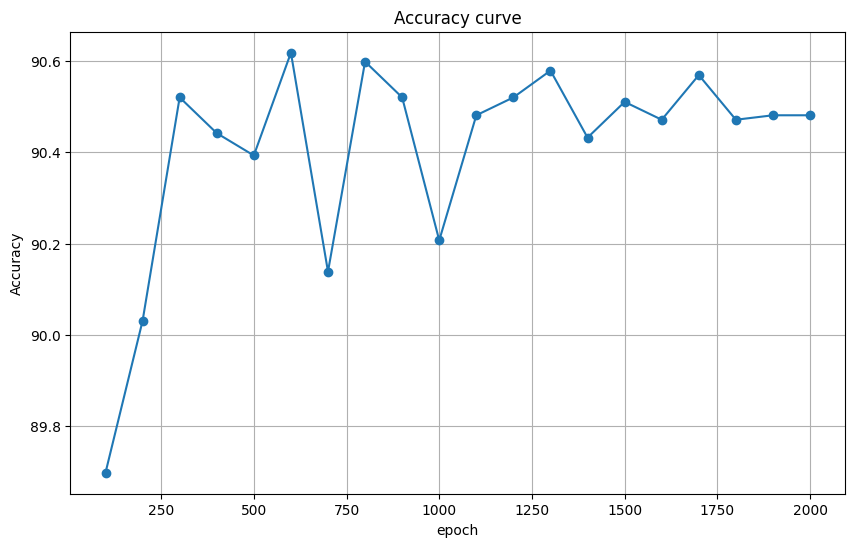

In [240]:
#x,y = generate_linear(n = 10000)
x = xor_hard_2_x
y = xor_hard_2_y
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
m = model(100)
m.set_optimizer(Momentum(0.9))
m.clear()
m.add_layer(2,4,sigmoid,derivative_sigmoid)
m.add_layer(4,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(2000,x,y,0.001,100,batch=32)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

loss=0.0012 accuracy=99.98%


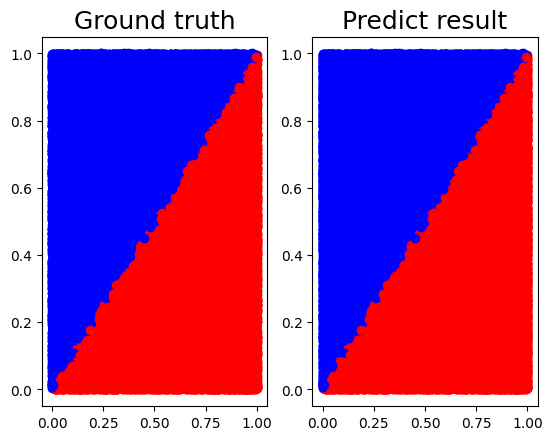

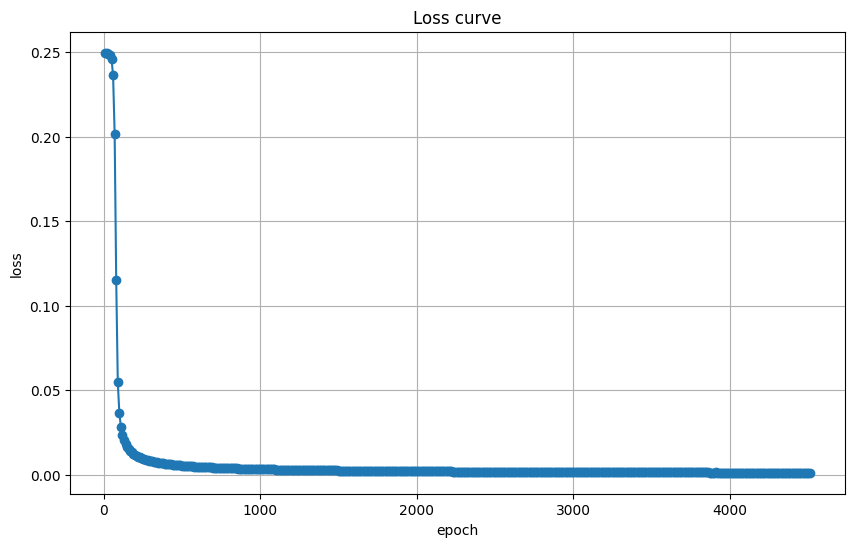

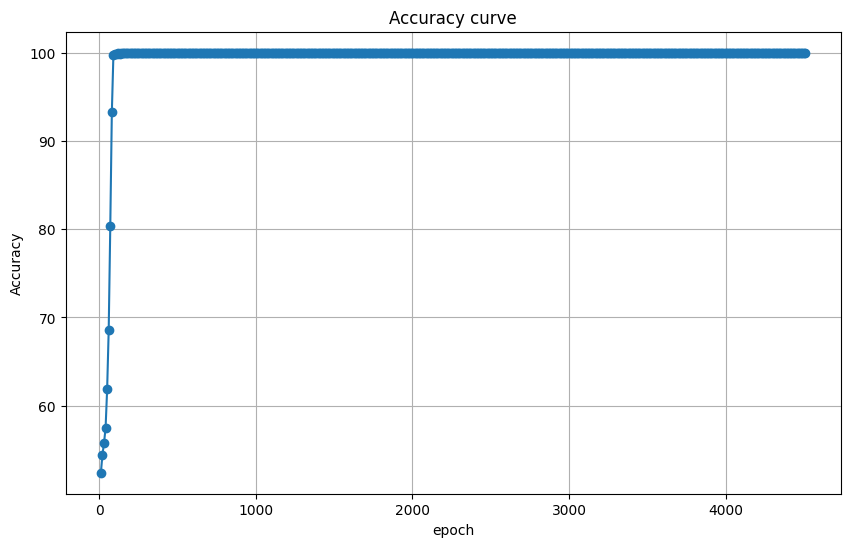

In [107]:
pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

epoch 100: loss : 0.0045996240 accuracy=99.90%
epoch 200: loss : 0.0032603654 accuracy=99.68%
epoch 300: loss : 0.0023055851 accuracy=99.94%
epoch 400: loss : 0.0020228288 accuracy=99.85%
epoch 500: loss : 0.0021528110 accuracy=99.71%
epoch 600: loss : 0.0022942630 accuracy=99.65%
epoch 700: loss : 0.0018161966 accuracy=99.78%
epoch 800: loss : 0.0016226429 accuracy=99.80%
epoch 900: loss : 0.0014118809 accuracy=99.85%
epoch 1000: loss : 0.0012347680 accuracy=99.95%
last accuracy=99.95%
loss=0.0012 accuracy=99.95%


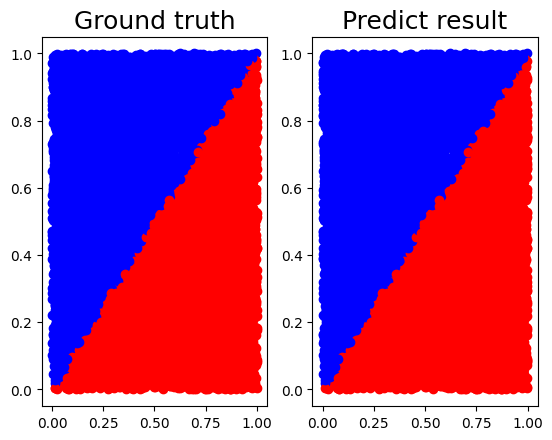

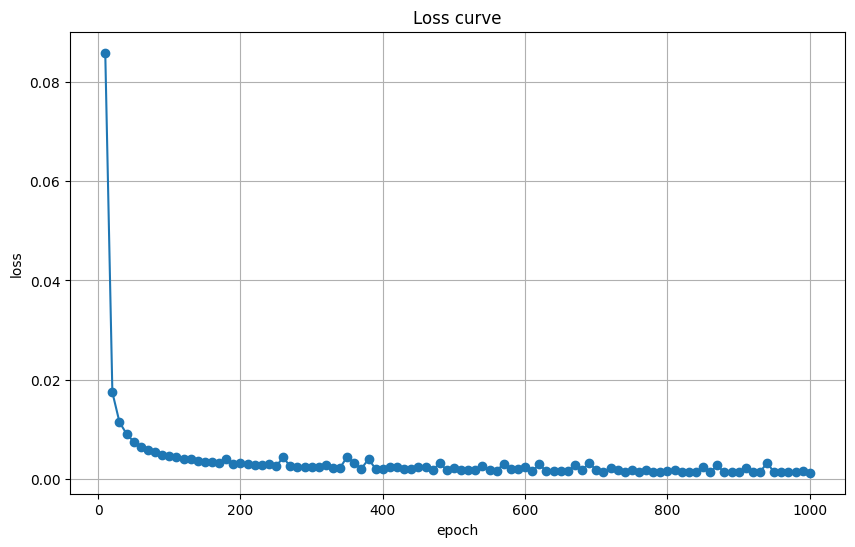

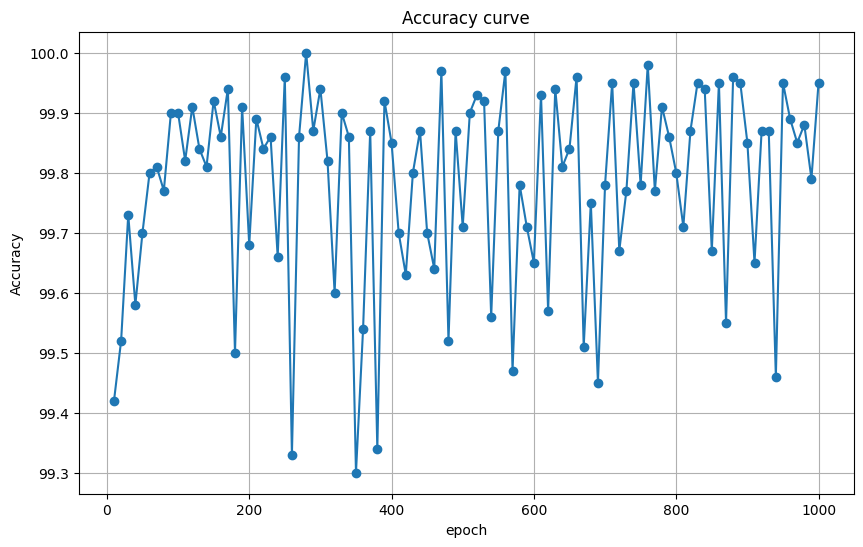

In [113]:
x,y = generate_linear(n = 10000)
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
m = model(10)
m.set_optimizer(Momentum(0.9))
m.clear()
m.add_layer(2,7,relu,derivative_relu)
m.add_layer(7,4,sigmoid,derivative_sigmoid)
m.add_layer(4,1,sigmoid,derivative_sigmoid)
m.training(1000,x,y,0.01,100,batch=32)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))
m.show_learning_curve_loss()
m.show_learning_curve_accuracy()

epoch 1000: loss : nan accuracy=52.38%
epoch 2000: loss : nan accuracy=52.38%
epoch 3000: loss : nan accuracy=52.38%
epoch 4000: loss : nan accuracy=52.38%
epoch 5000: loss : nan accuracy=52.38%
epoch 6000: loss : nan accuracy=52.38%
epoch 7000: loss : nan accuracy=52.38%
epoch 8000: loss : nan accuracy=52.38%
epoch 9000: loss : nan accuracy=52.38%
epoch 10000: loss : nan accuracy=52.38%
last accuracy=52.38%
loss=nan accuracy=52.38%


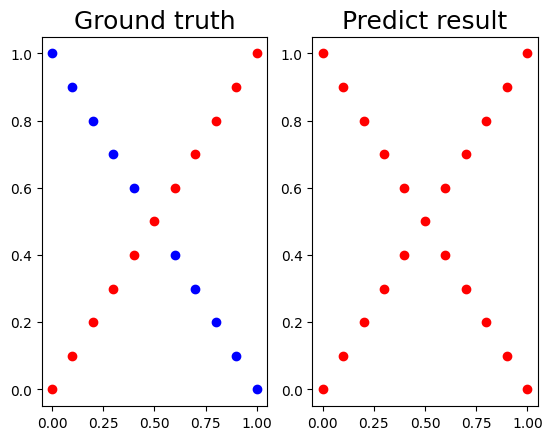

In [121]:
#x,y = generate_linear(n = 1000)
#x,y = generate_XOR_hard()
#x,y = generate_XOR_easy()
#x,y= generate_XOR_hard_2()
#x = moon_x
#y = moon_y
m = model(16)
m.clear()
#m.set_optimizer(Momentum(0.9))
m.add_layer(2,4)
m.add_layer(4,4)
m.add_layer(4,1)
m.training(10000,x,y,0.1,1000,batch=16)

pred_y = m.testing(x,y,show_info=False)
show_result(x,y,(pred_y > 0.5))